## Spark Dataframe: introduction
**Run this Notebook on GCP with Dataproc**

In [1]:
#Ensure we are using the right kernel
spark.version

'3.5.1'

In [2]:
import os
import subprocess
import shutil
import pandas as pd
# import sh
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col, sum, when
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import min, max
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import StopWordsRemover # PySpark currently does not directly support automatic stop word lists for languages other than English
from pyspark import SparkContext
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as F


In [3]:
pd.set_option("max_colwidth", 100)

#### Set-up COS functions for GCS

In [4]:
from google.cloud import storage
# !pip install gcsfs --upgrade

In [5]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [6]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns=['Name','Size'])

    blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

In [8]:
# Reading data from open bucket, avaible to all students
bucket_read = 'msca-bdp-data-open'

# Saving results into individual bucket, students must update to their own bucket
bucket_write = 'msca-bdp-data-shared'

### Check source data in COS

In [9]:
!gsutil ls -lh 'gs://msca-bdp-data-open/final_project_reviews/'

       0 B  2025-05-03T16:23:33Z  gs://msca-bdp-data-open/final_project_reviews/
                                 gs://msca-bdp-data-open/final_project_reviews/meta/
                                 gs://msca-bdp-data-open/final_project_reviews/meta_json/
                                 gs://msca-bdp-data-open/final_project_reviews/meta_light/
                                 gs://msca-bdp-data-open/final_project_reviews/meta_parquet/
                                 gs://msca-bdp-data-open/final_project_reviews/reviews/
                                 gs://msca-bdp-data-open/final_project_reviews/reviews_light/
                                 gs://msca-bdp-data-open/final_project_reviews/reviews_parquet/
TOTAL: 1 objects, 0 bytes (0 B)


In [10]:
list_blobs_pd(bucket_read,'final_project_reviews/meta_parquet').head()

,Name,Size
0,final_project_reviews/meta_parquet/,0
1,final_project_reviews/meta_parquet/_SUCCESS,0
2,final_project_reviews/meta_parquet/part-00000-b083b23b-4b22-49f9-83f6-09d844a46481-c000.snappy.p...,26443957
3,final_project_reviews/meta_parquet/part-00001-b083b23b-4b22-49f9-83f6-09d844a46481-c000.snappy.p...,26380726
4,final_project_reviews/meta_parquet/part-00002-b083b23b-4b22-49f9-83f6-09d844a46481-c000.snappy.p...,26339140


In [11]:
list_blobs_pd(bucket_read,'final_project_reviews/reviews_parquet').head()

,Name,Size
0,final_project_reviews/reviews_parquet/,0
1,final_project_reviews/reviews_parquet/_SUCCESS,0
2,final_project_reviews/reviews_parquet/part-00000-6663e9a0-1fd2-473d-80ea-51191b6cbbb8-c000.snapp...,232136358
3,final_project_reviews/reviews_parquet/part-00001-6663e9a0-1fd2-473d-80ea-51191b6cbbb8-c000.snapp...,231478535
4,final_project_reviews/reviews_parquet/part-00002-6663e9a0-1fd2-473d-80ea-51191b6cbbb8-c000.snapp...,231884240


Reading Reviews into Spark DF

In [12]:
reviews_path = "gs://msca-bdp-data-open/final_project_reviews/reviews_parquet"

In [13]:
reviews_df = spark.read.parquet(reviews_path, header='true', inferSchema='true', sep=',', quote='"')

#### Enable repl.eagerEval

This will output the results of DataFrames in each step without the need to use df.show() and also improves the formatting of the output


In [14]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [15]:
type(reviews_df)

pyspark.sql.dataframe.DataFrame

In [16]:
reviews_df.first()

Row(asin='B00HSAOFD8', helpful_vote=0, parent_asin='B00HSAOFD8', rating=4.0, text='Brushes arrived quickly and are a great value.', timestamp=1453819207000, title='Four Stars', user_id='AGWL43EG6H3AO3CN2WLIXE6YKPSQ', verified_purchase=True)

In [17]:
reviews_df.limit(5)

asin,helpful_vote,parent_asin,rating,text,timestamp,title,user_id,verified_purchase
B00HSAOFD8,0,B00HSAOFD8,4.0,Brushes arrived q...,1453819207000,Four Stars,AGWL43EG6H3AO3CN2...,true
B07MGKRMBG,0,B07SPY1GJG,5.0,I have tried just...,1600341347791,Finally a natural...,AGUUIUEN3Y4X54WXM...,true
B01FOJ7EVO,0,B09J7FM96G,4.0,Love Mediheal but...,1607280179211,Too small for me,AGOX7WJIY67A3OOKT...,true
B01B8ABHK2,0,B016O0QZEO,5.0,blended nicely wi...,1609835116809,Quality,AH26NV6K35W6YPPWJ...,true
B002W80GMK,0,B002W80GMK,5.0,Love this product,1520895879064,Five Stars,AHMBBCUUUIXNXTUAB...,true


In [18]:
reviews_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



In [19]:
reviews_df.describe().show()

25/05/30 18:55:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-----------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|summary|                asin|     helpful_vote|         parent_asin|            rating|        text|           timestamp|               title|             user_id|
+-------+--------------------+-----------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|  count|            64679785|         64679785|            64679785|          64679785|    64679785|            64679785|            64679785|            64679785|
|   mean| 6.382999448114565E9|0.798328643176535| 5.540557383940865E9|4.1026346794442805|         NaN|1.558042820558402E12|                 NaN|                NULL|
| stddev|3.7398314708787374E9|9.470284194770548|3.8531134761363397E9|1.4202268504208364|         NaN|8.757974968318881E10|                 NaN|                NULL|
|    min| 

Reading Metadata into Spark DF

In [20]:
meta_path = "gs://msca-bdp-data-open/final_project_reviews/meta_parquet"

In [21]:
meta_df = spark.read.parquet(meta_path, header='true', inferSchema='true', sep=',', quote='"')

In [22]:
type(meta_df)

pyspark.sql.dataframe.DataFrame

In [23]:
meta_df.first()

Row(author=None, average_rating=5.0, bought_together=None, categories=['Beauty & Personal Care', 'Skin Care', 'Face', 'Treatments & Masks', 'Serums'], description=[], main_category='All Beauty', parent_asin='B0771WJBHK', price=None, rating_number=5, store='Bare Alchemy', subtitle=None, title='Soothe Serum for Dry and Sensitive Skin')

In [24]:
meta_df.limit(5)

author,average_rating,bought_together,categories,description,main_category,parent_asin,price,rating_number,store,subtitle,title
NULL,5.0,NULL,[Beauty & Persona...,[],All Beauty,B0771WJBHK,NULL,5,Bare Alchemy,NULL,Soothe Serum for ...
NULL,4.0,NULL,[Beauty & Persona...,[],NULL,B09NKNNS57,NULL,17,DISCOVER DEVICE,NULL,DISCOVER Tattoo B...
NULL,4.6,NULL,[Beauty & Persona...,[],All Beauty,B0C6FF5HWL,8.99,137,auroray,NULL,auroray 2200 Pcs ...
NULL,1.0,NULL,[Beauty & Persona...,[],NULL,B09NKSHV3Z,15.69,2,KKNC,NULL,KKNC Chemistry In...
NULL,5.0,NULL,[Beauty & Persona...,[Introduced by th...,All Beauty,B000C213AC,NULL,1,Fine Fragrances,NULL,Aficionado By Fin...


In [25]:
meta_df.printSchema()

root
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- avatar: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_category: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- store: string (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- title: string (nullable = true)



In [26]:
meta_df.describe().show()

+-------+------------------+---------------+--------------+--------------------+------------------+------------------+-------------+--------------------+--------------------+
|summary|    average_rating|bought_together| main_category|         parent_asin|             price|     rating_number|        store|            subtitle|               title|
+-------+------------------+---------------+--------------+--------------------+------------------+------------------+-------------+--------------------+--------------------+
|  count|           4320533|              0|       4071089|             4320533|           1764838|           4320533|      4232718|                2335|             4320533|
|   mean|4.0742920838700165|           NULL|          NULL| 6.052491523284146E9|61.581236288291485|119.66084577990725|     Infinity|                NULL|                 NaN|
| stddev|0.8341559923672672|           NULL|          NULL|3.7845163435848427E9|132.55754504634876| 1049.986075389331|       

## Reviews EDA 

In [27]:
null_counts = reviews_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in reviews_df.columns
])
null_counts.show()

+----+------------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+-----------+------+----+---------+-----+-------+-----------------+
|   0|           0|          0|     0|   0|        0|    0|      0|                0|
+----+------------+-----------+------+----+---------+-----+-------+-----------------+



No null values in any column

In [28]:
for column in reviews_df.columns:
    unique_count = reviews_df.select(column).distinct().count()
    print(f"{column}: {unique_count} unique values")

asin: 5318892 unique values


helpful_vote: 1503 unique values


parent_asin: 4320211 unique values


rating: 5 unique values


text: 55283078 unique values


timestamp: 62701390 unique values


title: 25211484 unique values


user_id: 22789619 unique values


verified_purchase: 2 unique values


In [29]:
reviews_df = reviews_df.withColumn(
    "timestamp",
    from_unixtime(col("timestamp") / 1000)
)

In [30]:
reviews_df.limit(5)

asin,helpful_vote,parent_asin,rating,text,timestamp,title,user_id,verified_purchase
B00HSAOFD8,0,B00HSAOFD8,4.0,Brushes arrived q...,2016-01-26 14:40:07,Four Stars,AGWL43EG6H3AO3CN2...,true
B07MGKRMBG,0,B07SPY1GJG,5.0,I have tried just...,2020-09-17 11:15:47,Finally a natural...,AGUUIUEN3Y4X54WXM...,true
B01FOJ7EVO,0,B09J7FM96G,4.0,Love Mediheal but...,2020-12-06 18:42:59,Too small for me,AGOX7WJIY67A3OOKT...,true
B01B8ABHK2,0,B016O0QZEO,5.0,blended nicely wi...,2021-01-05 08:25:16,Quality,AH26NV6K35W6YPPWJ...,true
B002W80GMK,0,B002W80GMK,5.0,Love this product,2018-03-12 23:04:39,Five Stars,AHMBBCUUUIXNXTUAB...,true


In [31]:
reviews_df.select(
    min("timestamp").alias("min_timestamp"),
    max("timestamp").alias("max_timestamp")
).show()

+-------------------+-------------------+
|      min_timestamp|      max_timestamp|
+-------------------+-------------------+
|1998-01-19 16:58:28|2023-09-13 16:30:23|
+-------------------+-------------------+



In [32]:
from pyspark.sql.functions import to_date

# Extract just the date portion
reviews_df = reviews_df.withColumn("review_date", to_date("timestamp"))

# Group and count
daily_counts = reviews_df.groupBy("review_date").count().orderBy("review_date")

In [33]:
daily_counts_pd = daily_counts.toPandas()

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


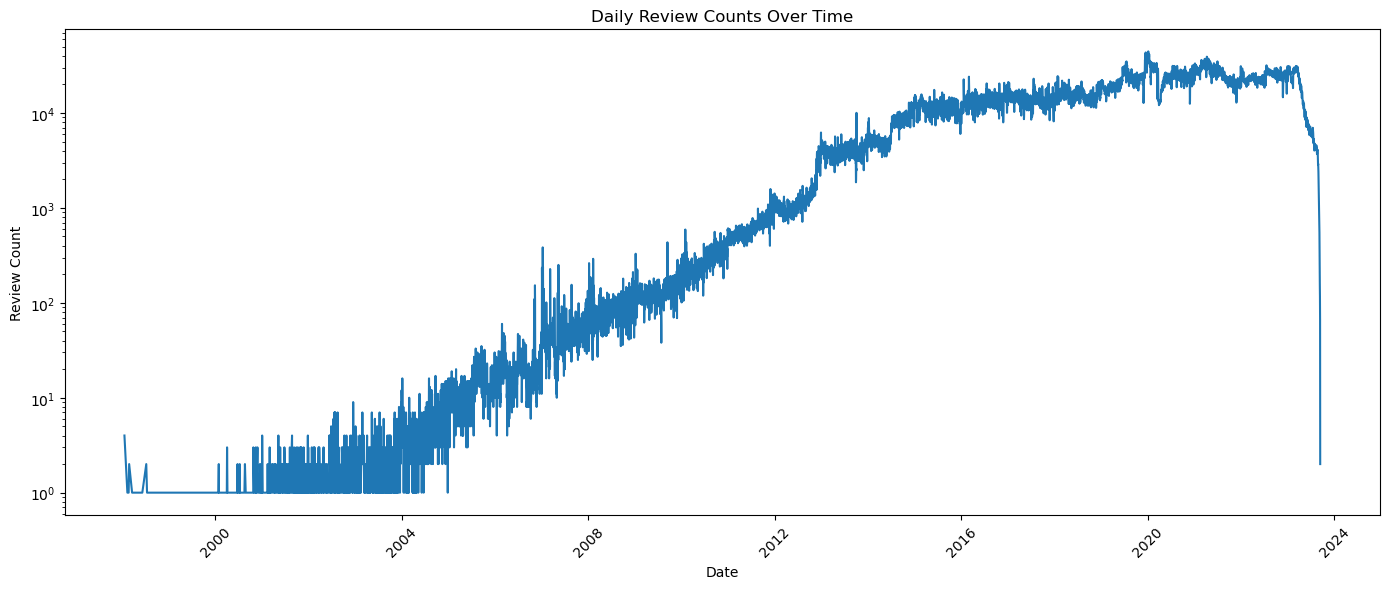

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_counts_pd, x="review_date", y="count")
plt.title("Daily Review Counts Over Time")
plt.yscale("log")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
reviews_group = reviews_df.groupBy("rating").count().orderBy("rating")

In [36]:
reviews_group.limit(5)

rating,count
1.0,7945517
2.0,3378242
3.0,4444637
4.0,7235328
5.0,41676061


In [37]:
reviews_group = reviews_group.toPandas()

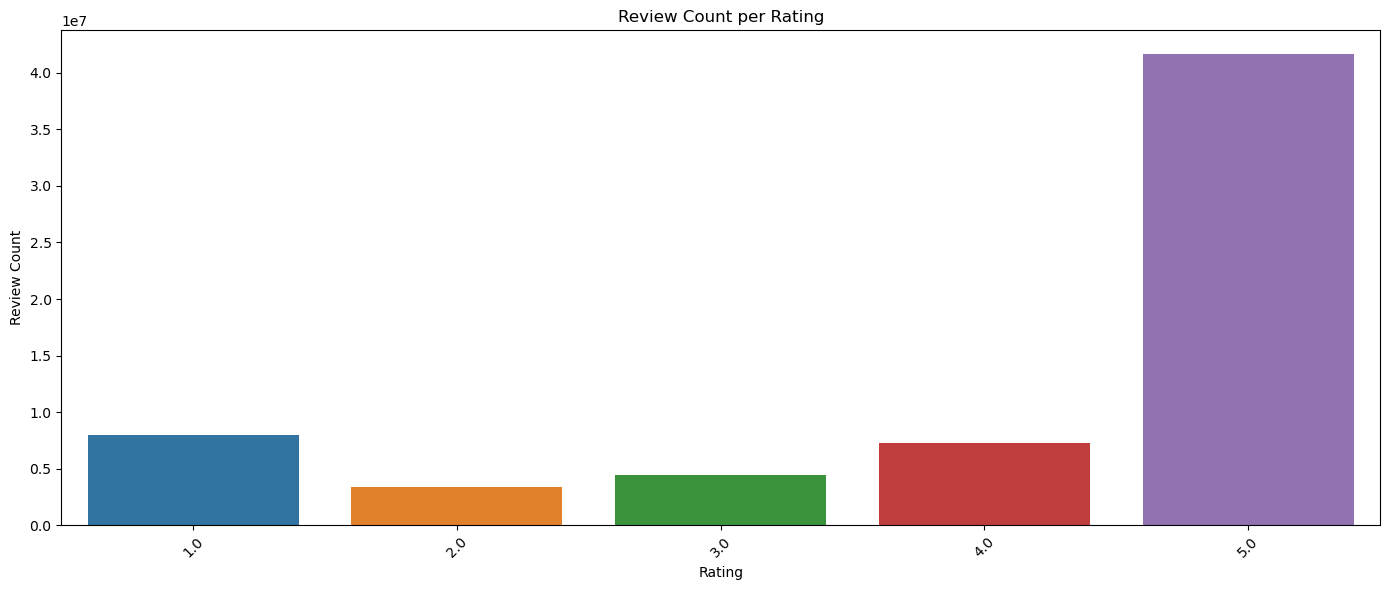

In [38]:
plt.figure(figsize=(14, 6))
sns.barplot(data=reviews_group, x="rating",y="count")
plt.title("Review Count per Rating")
#plt.yscale("log")
plt.xlabel("Rating")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
user_review_counts = reviews_df.groupBy("user_id").count()
user_review_counts.orderBy(col("count").desc()).show(10)

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|AG73BVBKUOH22USSF...| 3448|
|AGZUJTI7A3JFKB4FP...| 2394|
|AEMP3A7IKW37CMWFX...| 2328|
|AFXF3EGQTQDXMRLDW...| 2031|
|AH2DN3Q2OKAW7JAFR...| 1917|
|AEAXAJACFMXIAAH4W...| 1849|
|AEZP6Z2C5AVQDZAJE...| 1784|
|AFF6DS6NOWRIF2ARO...| 1574|
|AHV6QCNBJNSGLATP5...| 1480|
|AGYVC7KVHP2AWM7BD...| 1358|
+--------------------+-----+
only showing top 10 rows



In [40]:
from pyspark.sql.functions import col, expr

# Compute Q1 and Q3 using approxQuantile
quantiles = user_review_counts.approxQuantile("count", [0.25, 0.75], 0.05)
Q1, Q3 = quantiles
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = user_review_counts.filter((col("count") > upper_bound))
outliers.show(5)

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|AFCHOV5GQBMFLDGBG...|   20|
|AEMFE5OOKZNJJUWGC...|   21|
|AHOP5WR5Z6GCXLBVK...|    8|
|AESQAON3WDUDVHFDL...|   10|
|AGVKYQ5PU7L2EIUN4...|   25|
+--------------------+-----+
only showing top 5 rows



In [41]:
outliers.describe().show()

+-------+--------------------+------------------+
|summary|             user_id|             count|
+-------+--------------------+------------------+
|  count|             1854038|           1854038|
|   mean|                NULL| 13.09498456881682|
| stddev|                NULL|14.441025769176012|
|    min|AE2222VGHFD37G7NO...|                 7|
|    max|AHZZZZYA4NULLM5PN...|              3448|
+-------+--------------------+------------------+



In [42]:
reviews_group_v = reviews_df.groupBy("verified_purchase").count()

In [43]:
reviews_group_v.limit(5)

verified_purchase,count
true,60719745
false,3960040


In [44]:
reviews_group_v = reviews_group_v.toPandas()

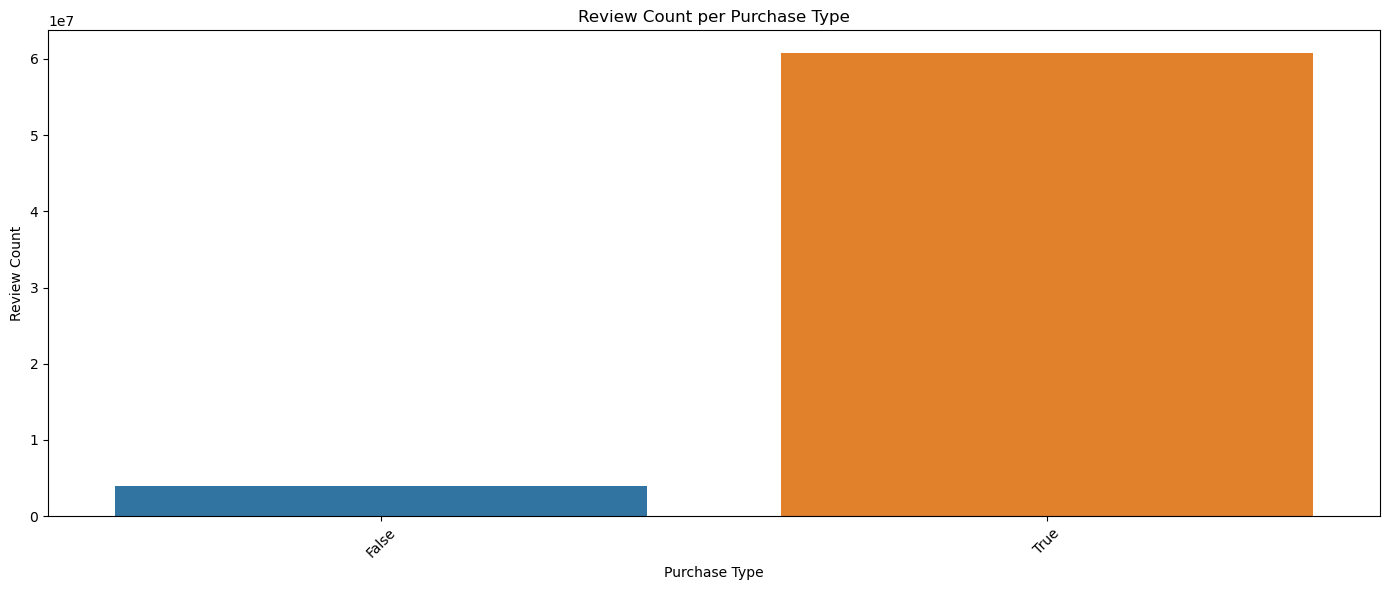

In [45]:
plt.figure(figsize=(14, 6))
sns.barplot(data=reviews_group_v, x="verified_purchase",y="count")
plt.title("Review Count per Purchase Type")
#plt.yscale("log")
plt.xlabel("Purchase Type")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# EDA for Metadata

In [46]:
meta_df.limit(5)

author,average_rating,bought_together,categories,description,main_category,parent_asin,price,rating_number,store,subtitle,title
NULL,5.0,NULL,[Beauty & Persona...,[],All Beauty,B0771WJBHK,NULL,5,Bare Alchemy,NULL,Soothe Serum for ...
NULL,4.0,NULL,[Beauty & Persona...,[],NULL,B09NKNNS57,NULL,17,DISCOVER DEVICE,NULL,DISCOVER Tattoo B...
NULL,4.6,NULL,[Beauty & Persona...,[],All Beauty,B0C6FF5HWL,8.99,137,auroray,NULL,auroray 2200 Pcs ...
NULL,1.0,NULL,[Beauty & Persona...,[],NULL,B09NKSHV3Z,15.69,2,KKNC,NULL,KKNC Chemistry In...
NULL,5.0,NULL,[Beauty & Persona...,[Introduced by th...,All Beauty,B000C213AC,NULL,1,Fine Fragrances,NULL,Aficionado By Fin...


In [47]:
meta_df.printSchema()

root
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- avatar: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_category: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- store: string (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- title: string (nullable = true)



In [48]:
meta_df.select("author.name") \
    .filter(col("author.name").isNotNull()) \
    .show(5, truncate=False)

+--------------------+
|name                |
+--------------------+
|Ellis Amdur         |
|Adrienne Morris     |
|Lydia Maria Gurney  |
|Kerstin Schmitt     |
|Cyclepedia Press LLC|
+--------------------+
only showing top 5 rows



In [49]:
meta_df.select("author.about") \
    .filter(col("author.about").isNotNull()) \
    .show(5, truncate=True)

+--------------------+
|               about|
+--------------------+
|[Ellis Amdur bala...|
|[Adrienne's first...|
|[Discover more of...|
|[Discover more of...|
|[Cyclepedia.com b...|
+--------------------+
only showing top 5 rows



In [50]:
meta_df.select("categories").show(5, truncate=False)


+----------------------------------------------------------------------------------------------------------+
|categories                                                                                                |
+----------------------------------------------------------------------------------------------------------+
|[Beauty & Personal Care, Skin Care, Face, Treatments & Masks, Serums]                                     |
|[Beauty & Personal Care, Personal Care, Piercing & Tattoo Supplies, Tattoo Supplies, Tattoo Machine Parts]|
|[Beauty & Personal Care, Hair Care, Hair Accessories, Elastics & Ties]                                    |
|[Beauty & Personal Care, Fragrance, Men's, Cologne]                                                       |
|[Beauty & Personal Care, Fragrance, Men's, Sets]                                                          |
+----------------------------------------------------------------------------------------------------------+
only showing top 5 

In [51]:
from pyspark.sql.functions import col, explode, size, element_at

# Flatten struct fields: author.name → author_name
meta_flat = meta_df \
    .withColumn("author_name", col("author.name")) \
    .withColumn("author_avatar", col("author.avatar")) \
    .withColumn("author_about", col("author.about")) \
    .drop("author")  # Drop original nested struct

# Flatten array fields: keep first element for simplicity
meta_flat = meta_flat \
    .withColumn("category", element_at(col("categories"), 1)) \
    .withColumn("category_description", element_at(col("description"), 1)) \
    .drop("categories", "description")  # Drop arrays (or keep them)

meta_flat = meta_flat \
    .withColumn("author_element", element_at(col("author_about"), 1)) \
    .drop("author_about")


# Result: fully flat table
meta_flat.printSchema()

root
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- store: string (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- title: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- author_avatar: string (nullable = true)
 |-- category: string (nullable = true)
 |-- category_description: string (nullable = true)
 |-- author_element: string (nullable = true)



In [52]:
meta_flat = meta_flat.select('author_name',
 'author_avatar','author_element','average_rating',
 'bought_together',
 'main_category','category',
 'category_description',
 'parent_asin',
 'price',
 'rating_number',
 'store',
 'subtitle',
 'title')

In [53]:
meta_flat.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+---------------+--------------+--------------------+--------------------+--------------------+-----------------+------------------+-------------+--------------------+--------------------+
|summary|         author_name|       author_avatar|      author_element|    average_rating|bought_together| main_category|            category|category_description|         parent_asin|            price|     rating_number|        store|            subtitle|               title|
+-------+--------------------+--------------------+--------------------+------------------+---------------+--------------+--------------------+--------------------+--------------------+-----------------+------------------+-------------+--------------------+--------------------+
|  count|                 156|                 156|                 156|           4320533|              0|       4071089|             3965397|             2465045

In [54]:
for column in meta_flat.columns:
    unique_count = meta_flat.select(column).distinct().count()
    print(f"{column}: {unique_count} unique values")

author_name: 106 unique values


author_avatar: 71 unique values


author_element: 69 unique values
average_rating: 41 unique values
bought_together: 1 unique values


main_category: 43 unique values


category: 7 unique values


category_description: 1418538 unique values


parent_asin: 4320533 unique values


price: 48602 unique values
rating_number: 12934 unique values


store: 295566 unique values
subtitle: 194 unique values


title: 4178415 unique values


In [55]:
meta_flat.limit(5)

author_name,author_avatar,author_element,average_rating,bought_together,main_category,category,category_description,parent_asin,price,rating_number,store,subtitle,title
NULL,NULL,NULL,5.0,NULL,All Beauty,Beauty & Personal...,NULL,B0771WJBHK,NULL,5,Bare Alchemy,NULL,Soothe Serum for ...
NULL,NULL,NULL,4.0,NULL,NULL,Beauty & Personal...,NULL,B09NKNNS57,NULL,17,DISCOVER DEVICE,NULL,DISCOVER Tattoo B...
NULL,NULL,NULL,4.6,NULL,All Beauty,Beauty & Personal...,NULL,B0C6FF5HWL,8.99,137,auroray,NULL,auroray 2200 Pcs ...
NULL,NULL,NULL,1.0,NULL,NULL,Beauty & Personal...,NULL,B09NKSHV3Z,15.69,2,KKNC,NULL,KKNC Chemistry In...
NULL,NULL,NULL,5.0,NULL,All Beauty,Beauty & Personal...,Introduced by the...,B000C213AC,NULL,1,Fine Fragrances,NULL,Aficionado By Fin...


In [56]:
# Total row count
total_rows = meta_flat.count()

# Compute % of nulls for each column
null_percentages = meta_flat.select([
    ((sum(when(col(c).isNull(), 1).otherwise(0)) / total_rows)*100).alias(c)
    for c in meta_flat.columns
])

null_percentages.limit(2)

author_name,author_avatar,author_element,average_rating,bought_together,main_category,category,category_description,parent_asin,price,rating_number,store,subtitle,title
99.99638933437147,99.99638933437147,99.99638933437147,0.0,100.0,5.773454340008513,8.219726593917926,42.94581247267409,0.0,59.152308291592725,0.0,2.0325038600561554,99.94595574203461,0.0


In [57]:
meta_flat = meta_flat.select('parent_asin', 'title', 'store',
 'main_category','category',
 'category_description',
 'price',
 'rating_number','average_rating',)

In [58]:
meta_flat.limit(5)

parent_asin,title,store,main_category,category,category_description,price,rating_number,average_rating
B0771WJBHK,Soothe Serum for ...,Bare Alchemy,All Beauty,Beauty & Personal...,NULL,NULL,5,5.0
B09NKNNS57,DISCOVER Tattoo B...,DISCOVER DEVICE,NULL,Beauty & Personal...,NULL,NULL,17,4.0
B0C6FF5HWL,auroray 2200 Pcs ...,auroray,All Beauty,Beauty & Personal...,NULL,8.99,137,4.6
B09NKSHV3Z,KKNC Chemistry In...,KKNC,NULL,Beauty & Personal...,NULL,15.69,2,1.0
B000C213AC,Aficionado By Fin...,Fine Fragrances,All Beauty,Beauty & Personal...,Introduced by the...,NULL,1,5.0


In [59]:
meta_flat.filter(col("main_category").isNull()) \
         .groupBy("category") \
         .count() \
         .orderBy("count", ascending=False) \
         .limit(5)

category,count
Cell Phones & Acc...,112432
Beauty & Personal...,102896
Automotive,34096
Motorcycle & Powe...,16
Heavy Duty & Comm...,4


In [60]:
meta_flat.filter(col("category").isNull()).limit(5)

parent_asin,title,store,main_category,category,category_description,price,rating_number,average_rating
B0034NKGRW,Outlaw T68 DOT Gl...,Outlaw Helmets,Automotive,NULL,NULL,NULL,5,4.7
B00LAQLJI0,Raptor Series 040...,Raptor Series,Automotive,NULL,Need more access ...,NULL,3,5.0
B08ZCL1CQ5,Black Bling Car S...,Sikawai,Automotive,NULL,NULL,NULL,15,4.8
B01BT97P94,Kool Vue HD70ER-S...,Kool-Vue,Automotive,NULL,NULL,89.48,2,4.4
B00F8TRDI0,TEXAS NATIVE Texa...,NULL,Automotive,NULL,NULL,NULL,3,3.6


In [61]:
meta_flat.filter(col("category").isNull()) \
         .groupBy("main_category") \
         .count() \
         .orderBy("count", ascending=False) \
         .limit(5)

main_category,count
Cell Phones & Acc...,249278
Automotive,105783
Fire Phone,75


In [62]:
meta_flat.filter(col("category_description").isNull()).limit(5)

parent_asin,title,store,main_category,category,category_description,price,rating_number,average_rating
B0771WJBHK,Soothe Serum for ...,Bare Alchemy,All Beauty,Beauty & Personal...,NULL,NULL,5,5.0
B09NKNNS57,DISCOVER Tattoo B...,DISCOVER DEVICE,NULL,Beauty & Personal...,NULL,NULL,17,4.0
B0C6FF5HWL,auroray 2200 Pcs ...,auroray,All Beauty,Beauty & Personal...,NULL,8.99,137,4.6
B09NKSHV3Z,KKNC Chemistry In...,KKNC,NULL,Beauty & Personal...,NULL,15.69,2,1.0
B09QJ4Y1V6,Hot Air Brush Hai...,LIUYX,NULL,Beauty & Personal...,NULL,NULL,2,2.5


In [63]:
meta_flat.filter((col("category").isNull() & col("main_category").isNull()) & ~col("category_description").isNull())

parent_asin,title,store,main_category,category,category_description,price,rating_number,average_rating


In [64]:
meta_flat.filter(col("price").isNull()).limit(5)

parent_asin,title,store,main_category,category,category_description,price,rating_number,average_rating
B0771WJBHK,Soothe Serum for ...,Bare Alchemy,All Beauty,Beauty & Personal...,NULL,NULL,5,5.0
B09NKNNS57,DISCOVER Tattoo B...,DISCOVER DEVICE,NULL,Beauty & Personal...,NULL,NULL,17,4.0
B000C213AC,Aficionado By Fin...,Fine Fragrances,All Beauty,Beauty & Personal...,Introduced by the...,NULL,1,5.0
B09QJ4Y1V6,Hot Air Brush Hai...,LIUYX,NULL,Beauty & Personal...,NULL,NULL,2,2.5
B002JQKSQO,BARBAR Titanium B...,Barbar,NULL,Beauty & Personal...,NULL,NULL,1,3.0


In [65]:
meta_flat.filter(col("price").isNull()) \
         .groupBy("main_category") \
         .count() \
         .orderBy("count", ascending=False) \
         .limit(5)

main_category,count
Cell Phones & Acc...,846322
Automotive,735678
All Beauty,459922
NULL,200847
Health & Personal...,47512


In [66]:
meta_flat.filter(col("price").isNull()) \
         .groupBy("category") \
         .count() \
         .orderBy("count", ascending=False) \
         .limit(5)

category,count
Cell Phones & Acc...,793446
Automotive,789006
Beauty & Personal...,648234
NULL,323558
Motorcycle & Powe...,1267


In [67]:
clean_meta_flat = meta_flat.na.drop(subset=['main_category','category'])

In [68]:
print("Original rows:", meta_flat.count())
print("Cleaned rows: ", clean_meta_flat.count())

Original rows: 4320533


Cleaned rows:  3715953


In [69]:
from pyspark.sql.functions import col, regexp_replace
from pyspark.sql.types import FloatType

# Clean and convert price column
clean_meta_flat = clean_meta_flat.withColumn(
    "price_float",
    regexp_replace(col("price"), "[$,]", "").cast(FloatType())
)

In [70]:
category_avg = clean_meta_flat.groupBy("main_category") \
    .avg("price_float") \
    .withColumnRenamed("avg(price_float)", "avg_price")

In [71]:
clean_meta_flat = clean_meta_flat.join(category_avg, on="main_category", how="left")

In [72]:
from pyspark.sql.functions import when

clean_meta_flat = clean_meta_flat.withColumn(
    "imputed_price",
    when(col("price_float").isNull(), col("avg_price")).otherwise(col("price_float"))
)

In [73]:
from pyspark.sql.functions import format_number

# Replace 'price' column with the imputed value (rounded to 2 decimal places, as string)
clean_meta_flat = clean_meta_flat.withColumn(
    "price",
    format_number(col("imputed_price"), 2)
).drop("price_float", "avg_price", "imputed_price")


In [74]:
clean_meta_flat.limit(5)

main_category,parent_asin,title,store,category,category_description,price,rating_number,average_rating
All Beauty,B0771WJBHK,Soothe Serum for ...,Bare Alchemy,Beauty & Personal...,NULL,26.51,5,5.0
All Beauty,B0C6FF5HWL,auroray 2200 Pcs ...,auroray,Beauty & Personal...,NULL,8.99,137,4.6
All Beauty,B000C213AC,Aficionado By Fin...,Fine Fragrances,Beauty & Personal...,Introduced by the...,26.51,1,5.0
All Beauty,B001I4GC8Q,Tom's of Maine Lo...,Tom's of Maine,Beauty & Personal...,NULL,76.03,1,2.0
Grocery,B01MSGFMJU,Grisi Neutral Soa...,Grisi,Beauty & Personal...,Neutral Gris Bath...,6.49,29,4.2


# Final Cleaning of Reviews

In [75]:
filtered_reviews_df = reviews_df.join(
    clean_meta_flat.select("parent_asin").distinct(),
    on="parent_asin",
    how="inner"
)

In [76]:
print(outliers.count())

1854038


In [77]:
filtered_reviews_df = filtered_reviews_df.join(
    outliers.select("user_id").distinct(),
    on="user_id",
    how="left_anti"
)

In [78]:
filtered_reviews_df = filtered_reviews_df.filter(col("verified_purchase")=="true")
filtered_reviews_df = filtered_reviews_df.drop("verified_purchase")

In [79]:
print("Original rows:", reviews_df.count())
print("Cleaned rows: ", filtered_reviews_df.count())

Original rows: 64679785


Cleaned rows:  36387798


In [80]:
filtered_reviews_df.limit(5)

user_id,parent_asin,asin,helpful_vote,rating,text,timestamp,title,review_date
AE222NQXWES2RIDV6...,B08QFLKGJV,B084QWYLHN,0,5.0,Really love the s...,2021-02-05 18:08:33,Detangle Leave-in...,2021-02-05
AE222NQXWES2RIDV6...,B00UHZXZ2S,B00UHZXZ2S,0,5.0,I like everything...,2022-03-23 15:33:37,I just love this ...,2022-03-23
AE222NQXWES2RIDV6...,B01HSKXS30,B01HSKXS30,1,5.0,The feel & look,2020-11-16 17:28:53,Softness,2020-11-16
AE222NQXWES2RIDV6...,B075GXS1XM,B075GXS1XM,0,5.0,"The feel, fix & p...",2022-03-23 15:14:43,Outstanding for t...,2022-03-23
AE222OOPALO5XZBN5...,B08FDC4GXZ,B08FDFG29N,0,1.0,I dropped my phon...,2021-01-28 18:33:14,Did not protect p...,2021-01-28


In [81]:
# Group and count
daily_counts_f = filtered_reviews_df.groupBy("review_date").count().orderBy("review_date")

In [82]:
daily_counts_pd_f = daily_counts_f.toPandas()

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


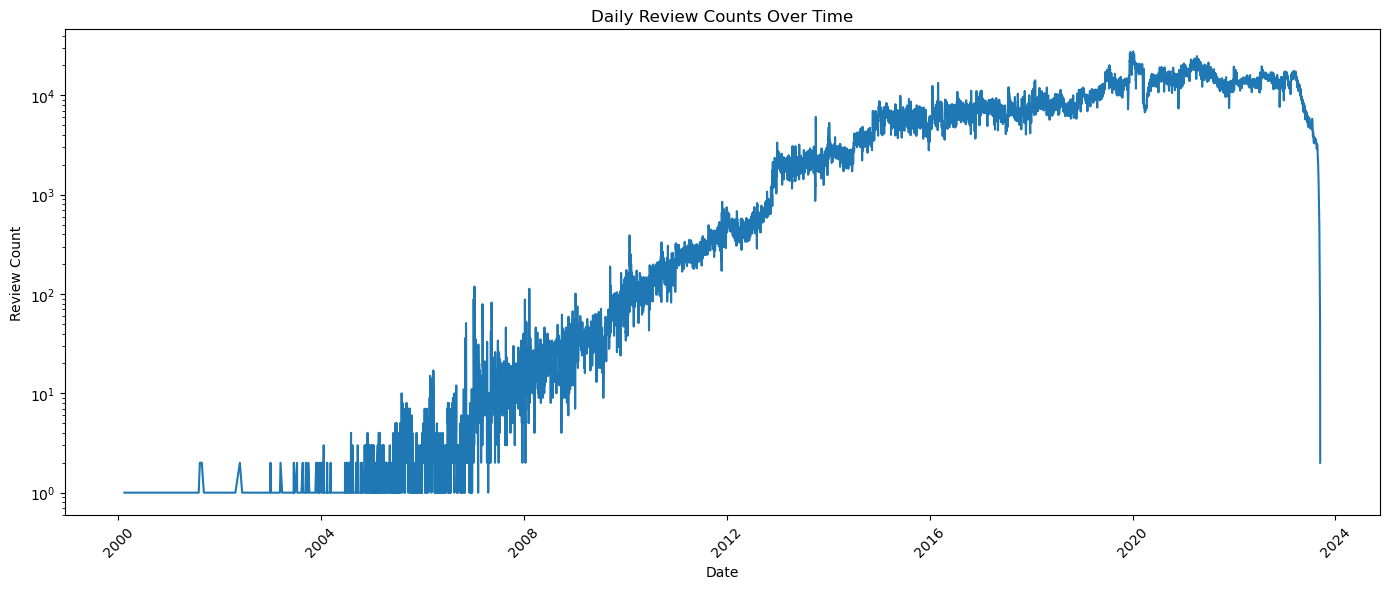

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_counts_pd_f, x="review_date", y="count")
plt.title("Daily Review Counts Over Time")
plt.yscale("log")
plt.xlabel("Date")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
# Create a 'year_month' column
filtered_reviews_df = filtered_reviews_df.withColumn(
    "year_month",
    concat_ws("-", year("review_date"), month("review_date"))
)

# Group by the new column and count
monthly_counts_f = filtered_reviews_df.groupBy("year_month").count().orderBy("year_month")

In [85]:
monthly_counts_pd_f = monthly_counts_f.toPandas()

# If not already datetime, convert for better control
#monthly_counts_pd_f["year_month"] = pd.to_datetime(monthly_counts_pd_f["year_month"])

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


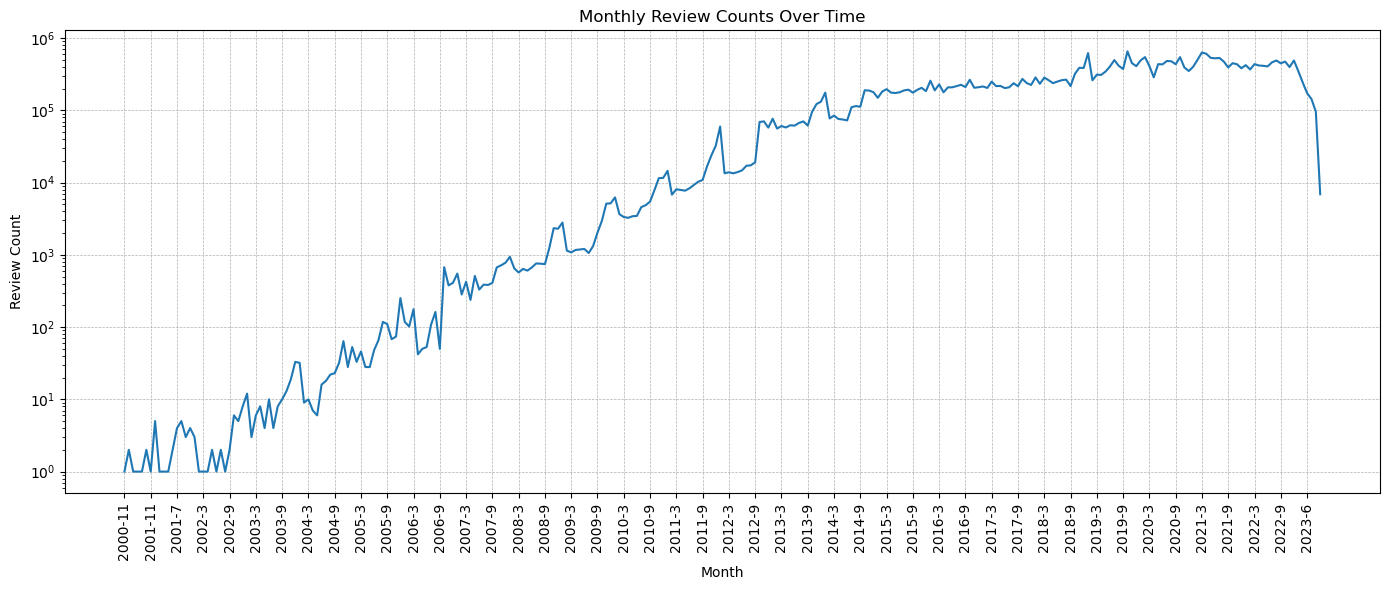

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_counts_pd_f, x="year_month", y="count")
plt.title("Monthly Review Counts Over Time")
plt.yscale("log")
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
xticks = monthly_counts_pd_f["year_month"].unique()
plt.xticks(ticks=range(0, len(xticks), 6), labels=xticks[::6], rotation=90)
plt.tight_layout()
plt.show()

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


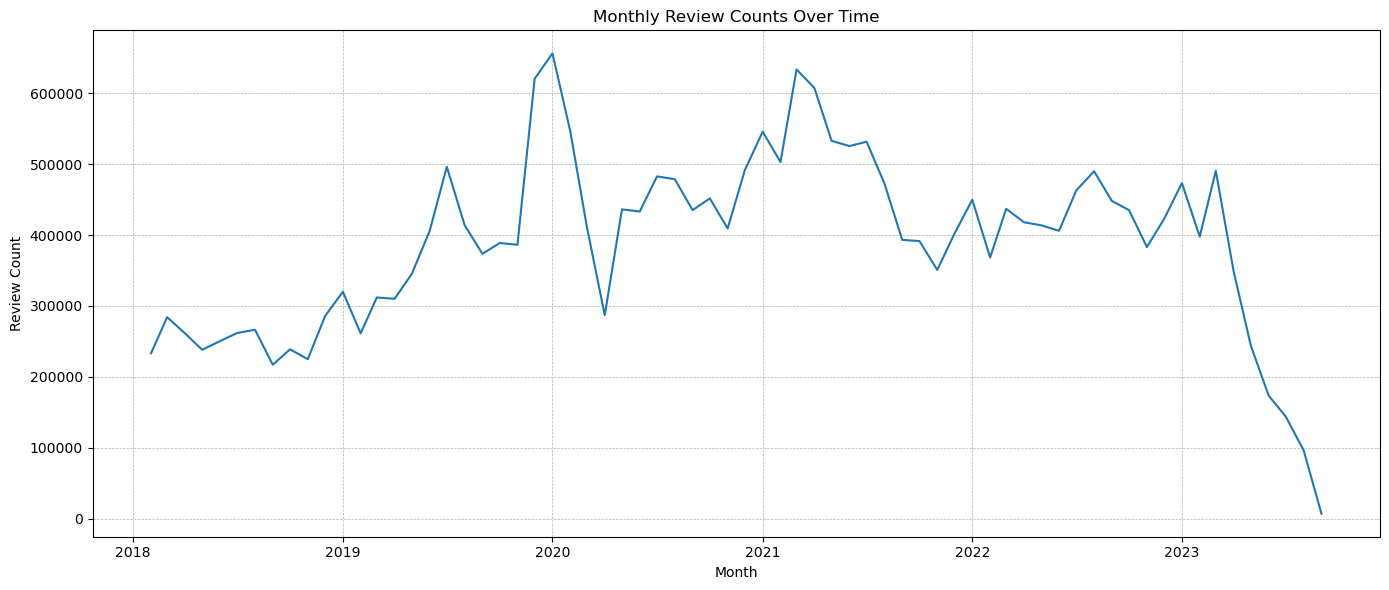

In [87]:
monthly_counts_pd_f["year_month"] = pd.to_datetime(monthly_counts_pd_f["year_month"])

# Filter data
filtered_df = monthly_counts_pd_f[monthly_counts_pd_f["year_month"] > "2018-01"]

plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered_df, x="year_month", y="count")
plt.title("Monthly Review Counts Over Time")
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
#plt.yscale("log")
plt.xlabel("Month")
plt.ylabel("Review Count")

plt.tight_layout()
plt.show()

We see a peak in the number of reviews during 2020. These could be due to the overall increase in online shopping due to lockdown during the Covid pandemic.

In [88]:
filtered_reviews_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- title: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year_month: string (nullable = false)



In [89]:
clean_meta_flat.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- store: string (nullable = true)
 |-- category: string (nullable = true)
 |-- category_description: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- average_rating: double (nullable = true)



In [90]:
clean_meta_flat = clean_meta_flat.withColumnRenamed("title", "meta_title")

In [91]:
joined_df = filtered_reviews_df.join(clean_meta_flat, on="parent_asin", how="inner")

In [96]:
joined_df.limit(5)

parent_asin,user_id,asin,helpful_vote,rating,text,timestamp,title,review_date,year_month,main_category,meta_title,store,category,category_description,price,rating_number,average_rating
1059270102,AFUCRKJV2WHUXBROM...,1059270102,0,1.0,This is a horribl...,2015-11-03 08:36:46,TERRIBLE product.,2015-11-03,2015-11,Industrial & Scie...,FULL Power Dr. Dr...,Factory Direct,Cell Phones & Acc...,FULL Power Dr. Dr...,45.69,1,1.0
9167523668,AGX4K5OHFMIOAY3WZ...,9167523668,0,5.0,It seems to be wo...,2017-05-29 12:39:30,Five Stars,2017-05-29,2017-5,All Beauty,Krack Happy Feet ...,Krack,Beauty & Personal...,NULL,9.00,9,3.0
9167523668,AFGQWSNQKC537O7IY...,9167523668,0,2.0,wrong stuff,2017-07-18 19:57:54,Two Stars,2017-07-18,2017-7,All Beauty,Krack Happy Feet ...,Krack,Beauty & Personal...,NULL,9.00,9,3.0
9167523668,AHVRUAIRJRFFNMR7K...,9167523668,0,5.0,Works great!,2016-07-25 20:24:59,Five Stars,2016-07-25,2016-7,All Beauty,Krack Happy Feet ...,Krack,Beauty & Personal...,NULL,9.00,9,3.0
9790773935,AEMBLRGWY2L3HEEKM...,9790773935,0,5.0,great,2016-05-24 18:16:25,Five Stars,2016-05-24,2016-5,All Beauty,Usher Cologne for...,Usher,Beauty & Personal...,Product Description,26.51,9,3.7


In [152]:
top_products_df = joined_df.groupBy("parent_asin", "meta_title") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)

In [153]:
top_products_df

parent_asin,meta_title,count
B01415QHYW,amFilm Screen Pro...,31156
B01LSUQSB0,REVLON One-Step V...,28250
B0BVGHXZJ1,essence | Lash Pr...,23806
B07P9S6R9Y,Yootech Wireless ...,20946
B001MA0QY2,HSI Professional ...,20038
B073R68TSH,Beam Electronics ...,19787
B01ITNRGFG,JOTO Universal Wa...,19091
B0C7CZXBBT,ThisWorx Car Vacu...,18145
B07H2V5YLH,Ailun Glass Scree...,18097
B0BYBCFHTB,Dr. Squatch All N...,17715


In [98]:
top_product_ids = [row['parent_asin'] for row in top_products_df.collect()]

In [99]:
top_reviews_df = joined_df.filter(col("parent_asin").isin(top_product_ids))

In [100]:
monthly_trends_df = top_reviews_df.groupBy("parent_asin", "year_month").count().orderBy("parent_asin", "year_month")

In [101]:
# Optional: merge product titles for better labels
product_titles = top_products_df.select("parent_asin", "meta_title").toPandas()
monthly_trends_pd = monthly_trends_df.toPandas()
monthly_trends_pd = monthly_trends_pd.merge(product_titles, on="parent_asin", how="left")

# Sort for better line continuity
monthly_trends_pd = monthly_trends_pd.sort_values(by=["parent_asin", "year_month"])

25/05/30 05:11:24 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.



In [102]:
monthly_trends_pd.head()

,parent_asin,year_month,count,meta_title
0,B001MA0QY2,2010-12,3,HSI Professional Glider Ceramic Flat Iron Hair Straightener - Pro Hairstyling Tool Plus Hair Tre...
1,B001MA0QY2,2011-10,41,HSI Professional Glider Ceramic Flat Iron Hair Straightener - Pro Hairstyling Tool Plus Hair Tre...
2,B001MA0QY2,2011-11,27,HSI Professional Glider Ceramic Flat Iron Hair Straightener - Pro Hairstyling Tool Plus Hair Tre...
3,B001MA0QY2,2011-12,38,HSI Professional Glider Ceramic Flat Iron Hair Straightener - Pro Hairstyling Tool Plus Hair Tre...
4,B001MA0QY2,2011-2,2,HSI Professional Glider Ceramic Flat Iron Hair Straightener - Pro Hairstyling Tool Plus Hair Tre...


In [103]:
# Truncate titles to 30 characters
monthly_trends_pd["short_title"] = monthly_trends_pd["meta_title"].str.slice(0, 30)


In [104]:
monthly_trends_df.limit(5)

25/05/30 05:11:34 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/30 05:11:42 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.



parent_asin,year_month,count
B001MA0QY2,2010-12,3
B001MA0QY2,2011-10,41
B001MA0QY2,2011-11,27
B001MA0QY2,2011-12,38
B001MA0QY2,2011-2,2


/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you wi

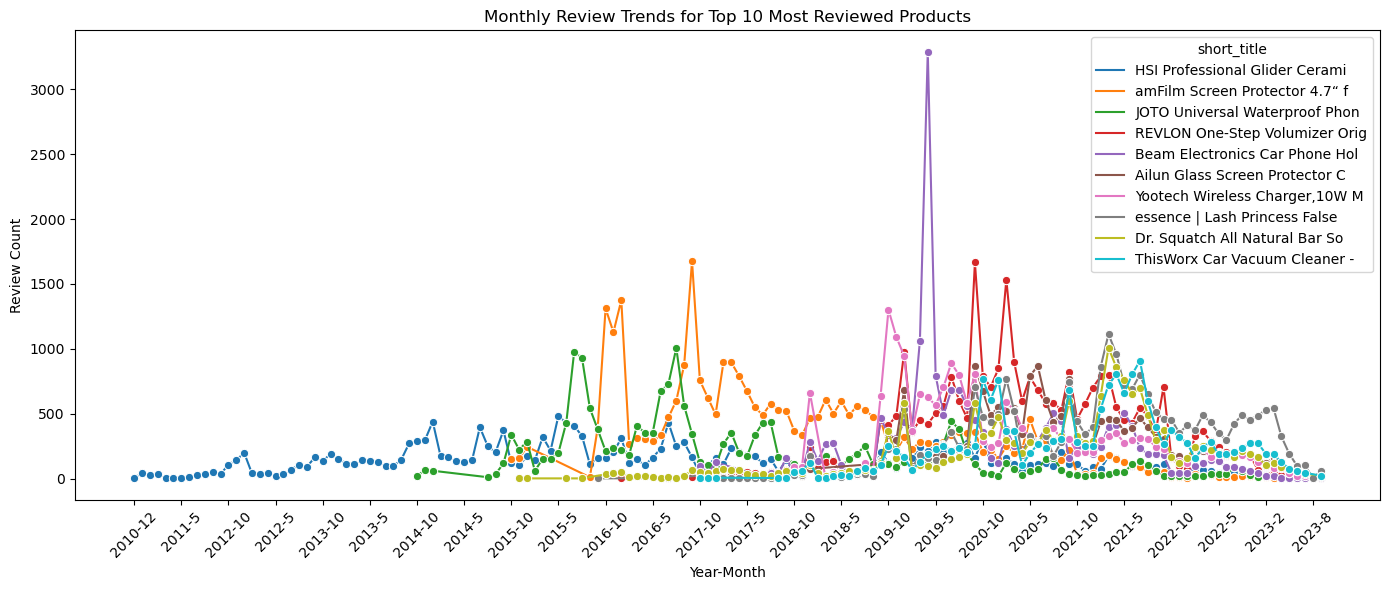

In [105]:
# Ensure year_month is sorted and unique
xticks = monthly_trends_pd["year_month"].unique()
xticks = sorted(xticks)  # ensure proper chronological order

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_pd, x="year_month", y="count", hue="short_title", marker="o")

plt.title("Monthly Review Trends for Top 10 Most Reviewed Products")
plt.xlabel("Year-Month")
plt.ylabel("Review Count")

# Show fewer x-ticks
plt.xticks(ticks=range(0, len(xticks), 6), labels=xticks[::6], rotation=45)

plt.tight_layout()
plt.show()

In [106]:
top_products_df = joined_df.groupBy("main_category") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)

In [107]:
top_categories = [row['main_category'] for row in top_products_df.collect()]

In [108]:
top_categories

['All Beauty',
 'Cell Phones & Accessories',
 'Automotive',
 'Health & Personal Care',
 'All Electronics',
 'Premium Beauty',
 'Amazon Home',
 'Tools & Home Improvement',
 'AMAZON FASHION',
 'Industrial & Scientific']

In [109]:
top_reviews_df = joined_df.filter(col("main_category").isin(top_categories))

In [110]:
monthly_trends_df = top_reviews_df.groupBy("main_category", "year_month").count().orderBy("main_category", "year_month")

In [111]:
# Optional: merge product titles for better labels
monthly_trends_pd = monthly_trends_df.toPandas()

# Sort for better line continuity
monthly_trends_pd = monthly_trends_pd.sort_values(by=["main_category", "year_month"])

In [112]:
monthly_trends_pd.head()

,main_category,year_month,count
0,AMAZON FASHION,2005-4,1
1,AMAZON FASHION,2006-11,1
2,AMAZON FASHION,2006-8,1
3,AMAZON FASHION,2007-10,1
4,AMAZON FASHION,2007-11,2


/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you wi

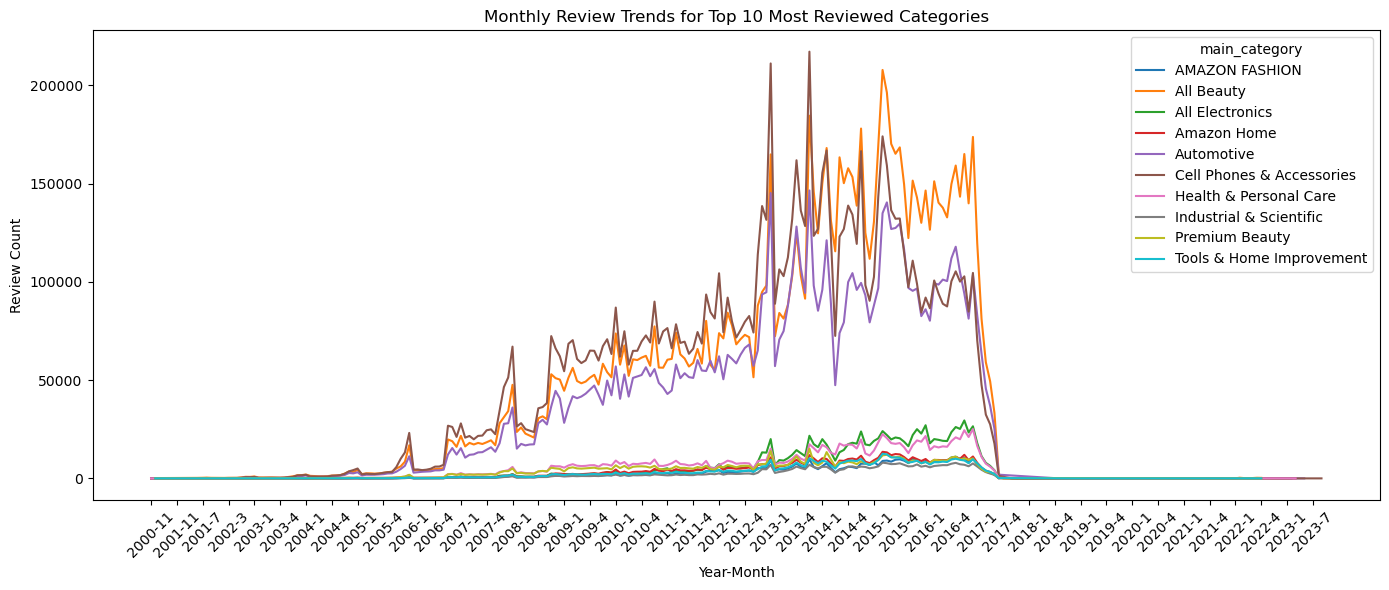

In [113]:
# Ensure year_month is sorted and unique
xticks = monthly_trends_pd["year_month"].unique()
xticks = sorted(xticks)  # ensure proper chronological order

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_pd, x="year_month", y="count", hue="main_category")

plt.title("Monthly Review Trends for Top 10 Most Reviewed Categories")
plt.xlabel("Year-Month")
plt.ylabel("Review Count")

# Show fewer x-ticks
plt.xticks(ticks=range(0, len(xticks), 6), labels=xticks[::6], rotation=45)

plt.tight_layout()
plt.show()

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


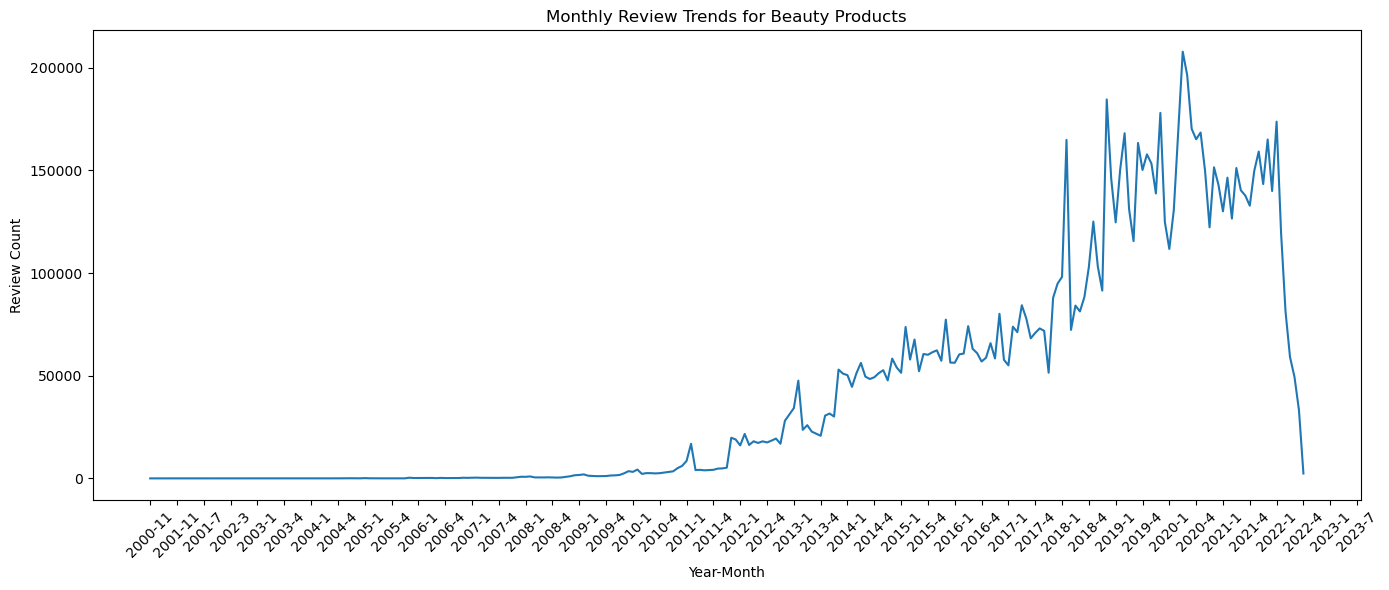

In [114]:
# Ensure year_month is sorted and unique
xticks = monthly_trends_pd["year_month"].unique()
xticks = sorted(xticks)  # ensure proper chronological order

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_pd[monthly_trends_pd['main_category']=="All Beauty"], x="year_month", y="count")

plt.title("Monthly Review Trends for Beauty Products")
plt.xlabel("Year-Month")
plt.ylabel("Review Count")

# Show fewer x-ticks
plt.xticks(ticks=range(0, len(xticks), 6), labels=xticks[::6], rotation=45)

plt.tight_layout()
plt.show()

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


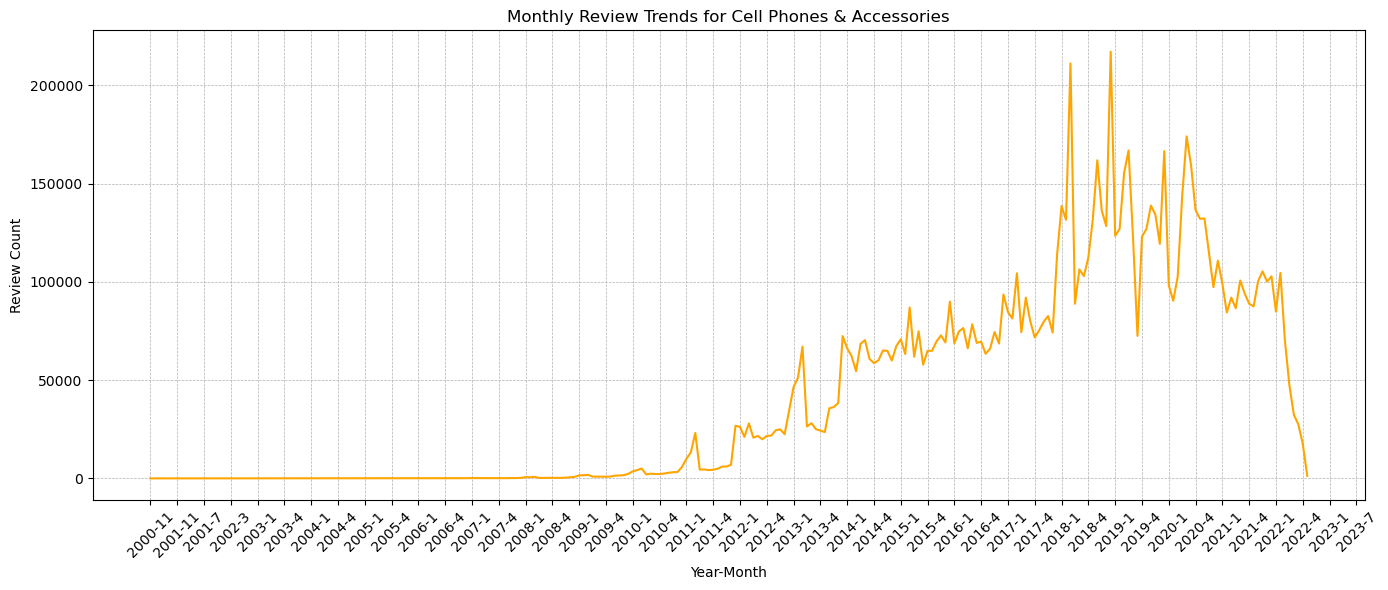

In [115]:
# Ensure year_month is sorted and unique
xticks = monthly_trends_pd["year_month"].unique()
xticks = sorted(xticks)  # ensure proper chronological order

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_pd[monthly_trends_pd['main_category']=="Cell Phones & Accessories"], x="year_month", y="count",color='Orange')

plt.title("Monthly Review Trends for Cell Phones & Accessories")
plt.xlabel("Year-Month")
plt.ylabel("Review Count")

# Show fewer x-ticks
plt.xticks(ticks=range(0, len(xticks), 6), labels=xticks[::6], rotation=45)

plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## See if top rated products are also most reviewed

In [116]:
top_products_df = joined_df.groupBy("parent_asin", "meta_title") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(50)

In [117]:
top_product_ids = [row['meta_title'] for row in top_products_df.collect()]

In [118]:
top_rated_products = joined_df.groupBy("parent_asin", "meta_title") \
    .mean("average_rating") \
    .orderBy(col("avg(average_rating)").desc()) \
    .filter(col("avg(average_rating)")>4.5)

In [119]:
top_rated_products = [row['meta_title'] for row in top_rated_products.collect()]

In [120]:
# Find intersection (products that are both highly reviewed and highly rated)
common_top_products = list(set(top_product_ids).intersection(set(top_rated_products)))

# Optional: Sort alphabetically or by length if needed
common_top_products.sort()

In [121]:
print(common_top_products)

['Ailun Glass Screen Protector Compatible for iPhone 11/XR,6.1 Inch 3 Pack Tempered Glass', 'Ailun Screen Protector Compatible for iPhone 8 plus,7 Plus,6s Plus,6 Plus, 5.5 Inch 3Pack Case Friendly Tempered Glass', 'Anker 2 Pack 313 Wireless Charger (Stand), Qi-Certified for iPhone 14/14 Pro/14 Pro Max/13/13 Pro Max, 10W Fast-Charging Galaxy S20, S10 (No AC Adapter)', 'Anker Portable Charger PowerCore 20100mAh - Ultra High Capacity Power Bank with 4.8A Output, External Battery Pack for iPhone, iPad & Samsung Galaxy & More (White)', 'Anker PowerCore 10000 Portable Charger, 10000mAh Power Bank, Ultra-Compact Battery Pack, High-Speed Charging Technology Phone Charger for iPhone, Samsung and More.', 'HEMPZ Body Lotion - Grapefruit & Raspberry Crème Daily Moisturizing Cream, Shea Butter Body Moisturizer - Skin Care Products, Hemp Seed Oil - Large', 'JETech Screen Protector for iPhone 7/8, 4.7-Inch, Tempered Glass Film, 2-Pack', 'JETech Screen Protector for iPhone 8 Plus and iPhone 7 Plus, 5.

In [123]:
len(common_top_products)

15

## Correlation plots between price and reviews

In [117]:
joined_df.limit(5)

parent_asin,user_id,asin,helpful_vote,rating,text,timestamp,title,review_date,year_month,main_category,meta_title,store,category,category_description,price,rating_number,average_rating
1059270102,AFUCRKJV2WHUXBROM...,1059270102,0,1.0,This is a horribl...,2015-11-03 08:36:46,TERRIBLE product.,2015-11-03,2015-11,Industrial & Scie...,FULL Power Dr. Dr...,Factory Direct,Cell Phones & Acc...,FULL Power Dr. Dr...,45.69,1,1.0
9167523668,AGX4K5OHFMIOAY3WZ...,9167523668,0,5.0,It seems to be wo...,2017-05-29 12:39:30,Five Stars,2017-05-29,2017-5,All Beauty,Krack Happy Feet ...,Krack,Beauty & Personal...,NULL,9.00,9,3.0
9167523668,AHVRUAIRJRFFNMR7K...,9167523668,0,5.0,Works great!,2016-07-25 20:24:59,Five Stars,2016-07-25,2016-7,All Beauty,Krack Happy Feet ...,Krack,Beauty & Personal...,NULL,9.00,9,3.0
9167523668,AFGQWSNQKC537O7IY...,9167523668,0,2.0,wrong stuff,2017-07-18 19:57:54,Two Stars,2017-07-18,2017-7,All Beauty,Krack Happy Feet ...,Krack,Beauty & Personal...,NULL,9.00,9,3.0
9790773935,AHRPQFTT6R5FJNZOP...,9790773935,0,5.0,Smells bomb,2016-12-16 05:48:06,Five Stars,2016-12-16,2016-12,All Beauty,Usher Cologne for...,Usher,Beauty & Personal...,Product Description,26.51,9,3.7


In [118]:
joined_df = joined_df.withColumn("price", col("price").cast("float"))

In [119]:
agg_df = joined_df.groupBy("parent_asin", "price") \
    .agg(
        {"rating": "avg", "*": "count"}
    ) \
    .withColumnRenamed("avg(rating)", "avg_rating") \
    .withColumnRenamed("count(1)", "review_volume")


In [120]:
agg_pd = agg_df.toPandas()


In [121]:
sampled_pd = agg_pd.sample(frac=0.1, random_state=42)

In [122]:
sampled_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280566 entries, 874114 to 2252715
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   parent_asin    280566 non-null  object 
 1   price          280243 non-null  float32
 2   avg_rating     280566 non-null  float64
 3   review_volume  280566 non-null  int64  
dtypes: float32(1), float64(1), int64(1), object(1)
memory usage: 9.6+ MB


In [123]:
price_range = joined_df.select(min("price").alias("min_price"),
                               max("price").alias("max_price")).collect()[0]
min_price = price_range["min_price"]
max_price = price_range["max_price"]

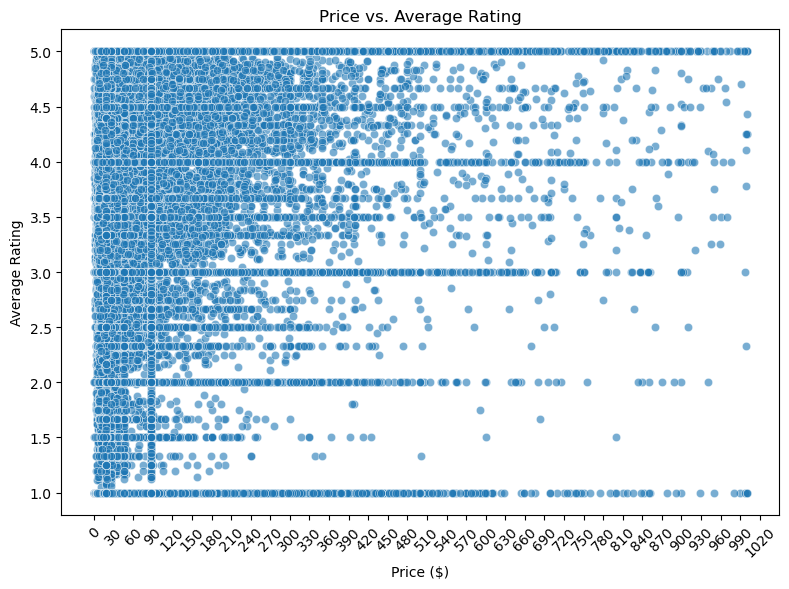

In [124]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=sampled_pd, x="price", y="avg_rating", alpha=0.6)

# Reduce tick labels
xticks = np.arange(min_price, max_price + 30, 30)
plt.xticks(ticks=xticks, rotation=45)

plt.title("Price vs. Average Rating")
plt.xlabel("Price ($)")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()

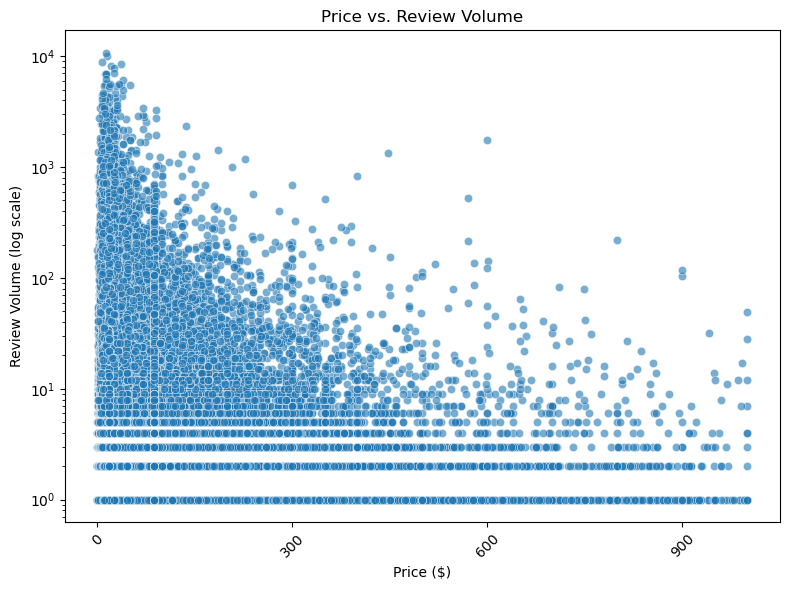

In [125]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=sampled_pd, x="price", y="review_volume", alpha=0.6)
plt.yscale("log")
# Reduce tick labels
xticks = np.arange(min_price, max_price + 30, 30)
plt.xticks(ticks=xticks[::10], rotation=45)
plt.title("Price vs. Review Volume")
plt.xlabel("Price ($)")
plt.ylabel("Review Volume (log scale)")
plt.tight_layout()
plt.show()


In [126]:
reviews_5_star = joined_df.filter(col("rating") == 5)
reviews_1_star = joined_df.filter(col("rating") == 1)

In [127]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [128]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[tokenizer, remover])

# For 5-star reviews
processed_5 = pipeline.fit(reviews_5_star).transform(reviews_5_star)
# For 1-star reviews
processed_1 = pipeline.fit(reviews_1_star).transform(reviews_1_star)


In [129]:
from pyspark.sql.functions import explode

# Count words
word_counts_5 = processed_5.select(explode("filtered_words").alias("word")) \
    .groupBy("word").count().orderBy("count", ascending=False)

word_counts_1 = processed_1.select(explode("filtered_words").alias("word")) \
    .groupBy("word").count().orderBy("count", ascending=False)


In [130]:
word_counts_5.show(20, truncate=False)
word_counts_1.show(20, truncate=False)


+-------+-------+
|word   |count  |
+-------+-------+
|great  |6146643|
|love   |4105392|
|product|3874937|
|good   |3085434|
|br     |3018555|
|easy   |3001914|
|phone  |2979139|
|case   |2656777|
|like   |2624374|
|use    |2598991|
|one    |2421621|
|hair   |2287619|
|well   |2270886|
|works  |2229814|
|perfect|1758741|
|really |1613338|
|price  |1508816|
|nice   |1420062|
|fit    |1391597|
|quality|1378462|
+-------+-------+
only showing top 20 rows



+-------+-------+
|word   |count  |
+-------+-------+
|product|1051691|
|br     |938419 |
|one    |847914 |
|phone  |847213 |
|like   |675568 |
|work   |592183 |
|case   |589482 |
|use    |540342 |
|money  |528618 |
|get    |505979 |
|fit    |503638 |
|even   |490877 |
|screen |481145 |
|buy    |453613 |
|hair   |434943 |
|time   |432844 |
|didn   |418454 |
|doesn  |409772 |
|used   |375005 |
|back   |368289 |
+-------+-------+
only showing top 20 rows



In [131]:
top_reviews_with_categories = joined_df.join(user_review_counts, on="user_id", how="inner") \
                                       .select("user_id", "main_category")

In [132]:
category_diversity = top_reviews_with_categories.groupBy("user_id") \
    .agg(countDistinct("main_category").alias("unique_categories")) \
    .orderBy(col("unique_categories").desc())

category_diversity.show(truncate=False)

25/05/29 21:05:08 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.



+----------------------------+-----------------+
|user_id                     |unique_categories|
+----------------------------+-----------------+
|AEBKFVLXJ45XK3FQT4RNYIRGBGQQ|6                |
|AEB2MCT3X57DYBUY4W2MUZHRLWFA|6                |
|AEDPUZWBRSONKIPWFHN6ANO7HZWQ|6                |
|AEFHP7QV5DRUEPXF4MD445C6GHEA|6                |
|AE2BQEZPWUZFK3ACD2YGSQSHJYPQ|6                |
|AEGP6C6CPCEHMGGDBM3DAVE6M3KA|6                |
|AHV4DPVS442D53YV7PW5XEWC54XA|6                |
|AEMEWGPDPUAJUBBME42LRNKPZOLQ|6                |
|AE2PZMJKDKXKKR625V7LTKPQTVEQ|6                |
|AENKMDVRICK3HQJFYTJDPYHCQUVQ|6                |
|AELPFEV54GMR47CPSK3RROYOC4XA|6                |
|AEPFMLGWU6WMHBWVSCNVDVEIXT5A|6                |
|AENP3CLGH4M62DBLODBKZVF5CKUQ|6                |
|AF4TSORZHP2EP67ANFP5ZVAO2JBQ|6                |
|AG2UJXOP6RM6PIBKOKVKZ4NDO7DQ|6                |
|AF64BKKU3LRVVRWLRBRQNLZFIEUQ|6                |
|AEGATTEUWSOU7W7RO4Z7IZDXMA3A|6                |
|AF74UQQY3IWXJTUKCO2

# Similarity Analysis

## For Titles in Industrial and Scientific Product category

In [93]:
def is_nonzero_vector(v):
    return isinstance(v, SparseVector) and len(v.indices) > 0

In [94]:
def similarity_analysis(df, text_col, jac):
    # Clean & filter
    df = df.select(text_col)
    df = df.filter(
        (col(text_col).isNotNull()) & (length(trim(col(text_col))) > 0)
    )
    df = df.withColumn("id", monotonically_increasing_id())
    
    # Text cleaning
    df = df.withColumn("clean_text", F.regexp_replace(F.col(text_col), "[^a-zA-Z0-9\\s]", ""))
    df = df.withColumn("words", split(F.col("clean_text"), " "))
    df = df.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))
    
    # Stopwords
    remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
    df = remover.transform(df)
    df = df.select("id", text_col, "filtered_words")
    df = df.filter(size(col("filtered_words")) > 0)
    
    # Vectorization
    vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
    vectorizer_model = vectorizer.fit(df)
    df_vectorized = vectorizer_model.transform(df)

    # Filter out zero vectors
    nonzero_vector_udf = udf(is_nonzero_vector, BooleanType())
    df_vectorized = df_vectorized.filter(nonzero_vector_udf(col("features")))

    # Optional: Sample to speed up
    df_vectorized = df_vectorized.sample(fraction=0.1, seed=42)

    # Fit LSH model
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model = mh.fit(df_vectorized)
    df_hashed = model.transform(df_vectorized)

    # Similarity join
    df_dups = model.approxSimilarityJoin(df_hashed, df_hashed, jac) \
        .filter("datasetA.id < datasetB.id") \
        .select(
            col("distCol"),
            col("datasetA").getField(text_col).alias("text_A"),
            col("datasetB").getField(text_col).alias("text_B")
        )

    return df_dups

In [133]:
top_categories

['All Beauty',
 'Cell Phones & Accessories',
 'Automotive',
 'Health & Personal Care',
 'All Electronics',
 'Premium Beauty',
 'Amazon Home',
 'Tools & Home Improvement',
 'AMAZON FASHION',
 'Industrial & Scientific']

In [154]:
industry_reviews = joined_df.filter(col("main_category")=="Industrial & Scientific")

In [135]:
print(industry_reviews.count())

410063


## for higher Jaccard distance

25/05/30 07:04:38 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 07:06:43 INFO PlanChangeLogger:                                        0]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 07:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1522.0 KiB
25/05/30 07:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1523.9 KiB
25/05/30 07:07:14 WARN DAGScheduler: Broadcasting large task binary with size 1531.5 KiB
25/05/30 07:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1529.6 KiB


Titles Duplicates


+-------+----------+----------+
|distCol|text_A    |text_B    |
+-------+----------+----------+
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
+-------+----------+----------+
only showing top 10 rows

Reviews Duplicates


25/05/30 07:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1540.7 KiB
25/05/30 07:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1543.3 KiB
25/05/30 07:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1645.9 KiB
25/05/30 07:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1557.5 KiB


+-------------------+------------------------------------------+-----------------------------------------------+
|distCol            |text_A                                    |text_B                                         |
+-------------------+------------------------------------------+-----------------------------------------------+
|0.0                |Does what it’s supposed to                |Does what it is supposed to do                 |
|0.0                |They fit                                  |Did not fit                                    |
|0.0                |Did not fit                               |Each fit                                       |
|0.33333333333333337|Nice fit                                  |Nice snug fit                                  |
|0.0                |fit was ok                                |Did not fit x6                                 |
|0.4                |Perfect fit! It was exactly what I needed!|It was exactly what I needed and

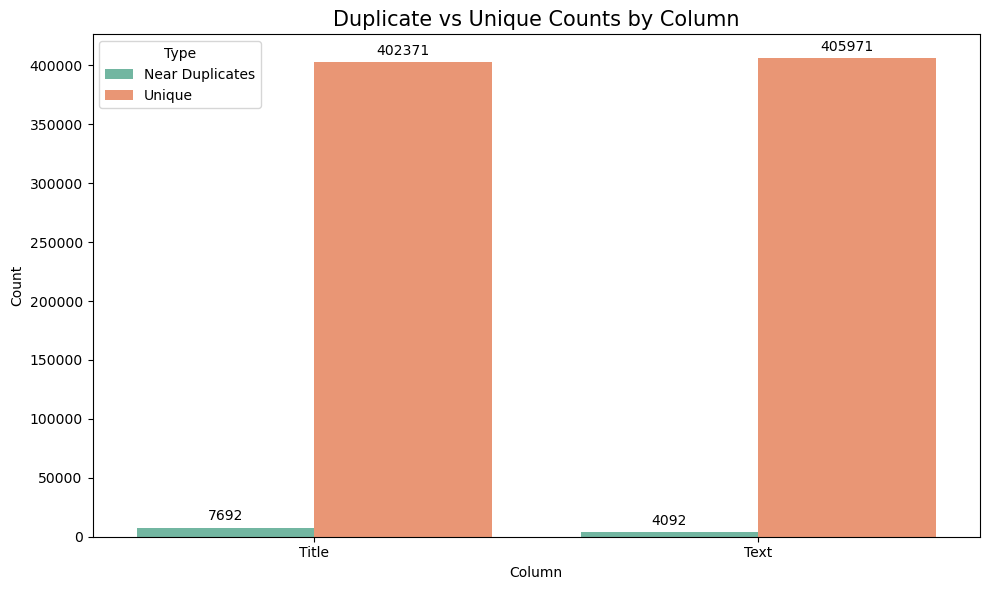

In [142]:
# ---- STEP 1: Filter by Product Category ----
industry_reviews = joined_df.filter(col("main_category")=="Industrial & Scientific")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(industry_reviews, "title", jac=0.5)
title_total = industry_reviews.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(industry_reviews, "text", jac=0.5)
text_total = industry_reviews.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

print("Titles Duplicates")
df_dups_title.show(10, truncate=False)

print("Reviews Duplicates")
df_dups_text.show(10, truncate=False)

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

## For lower Jaccard distance

25/05/30 07:11:18 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 07:13:13 INFO PlanChangeLogger:                                        ]]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 07:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1522.0 KiB
25/05/30 07:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1523.9 KiB
25/05/30 07:13:44 WARN DAGScheduler: Broadcasting large task binary with size 1531.5 KiB
25/05/30 07:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1529.6 KiB


Titles Duplicates


+-------+----------+----------+
|distCol|text_A    |text_B    |
+-------+----------+----------+
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
|0.0    |Five Stars|Five Stars|
+-------+----------+----------+
only showing top 10 rows

Reviews Duplicates


25/05/30 07:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1540.7 KiB
25/05/30 07:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1543.3 KiB
25/05/30 07:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1645.9 KiB
25/05/30 07:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1556.5 KiB


+-------+-------------+-------------+
|distCol|text_A       |text_B       |
+-------+-------------+-------------+
|0.0    |Great        |Great        |
|0.0    |Great product|Great product|
|0.0    |Great        |Great        |
|0.0    |Great        |Great        |
|0.0    |Great        |Great        |
|0.0    |Great        |Great        |
|0.0    |Great        |Great        |
|0.0    |Great product|Great product|
|0.0    |Great product|Great product|
|0.0    |Great product|Great product|
+-------+-------------+-------------+
only showing top 10 rows



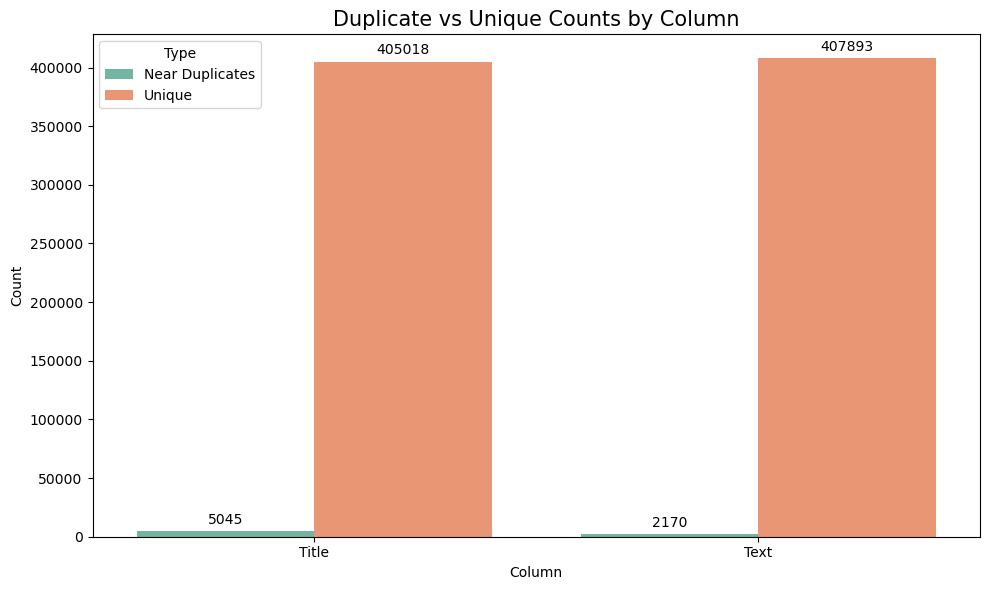

In [144]:
# ---- STEP 1: Filter by Product Category ----
industry_reviews = joined_df.filter(col("main_category")=="Industrial & Scientific")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(industry_reviews, "title", jac=0.3)
title_total = industry_reviews.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(industry_reviews, "text", jac=0.3)
text_total = industry_reviews.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

print("Titles Duplicates")
df_dups_title.show(10, truncate=False)

print("Reviews Duplicates")
df_dups_text.show(10, truncate=False)

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

## Duplicate Analysis for top 5 products

In [192]:
industry_reviews = joined_df.filter(col("main_category")=="Industrial & Scientific")

In [193]:
top_products_df = industry_reviews.groupBy("parent_asin") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5)

In [194]:
top_products = [row['parent_asin'] for row in top_products_df.collect()]

In [195]:
top_products

['B07JLQ24K9', 'B0C7F7HF75', 'B07DCRVBYX', 'B09H6H8B51', 'B08Y1G3KRX']

In [125]:
def similarity_analysis(df, text_col, jac):
    # Clean & filter
    df = df.select(text_col)
    df = df.filter(
        (col(text_col).isNotNull()) & (length(trim(col(text_col))) > 0)
    )
    df = df.withColumn("id", monotonically_increasing_id())
    
    # Text cleaning
    df = df.withColumn("clean_text", F.regexp_replace(F.col(text_col), "[^a-zA-Z0-9\\s]", ""))
    df = df.withColumn("words", split(F.col("clean_text"), " "))
    df = df.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))
    
    # Stopwords
    remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
    df = remover.transform(df)
    df = df.select("id", text_col, "filtered_words")
    df = df.filter(size(col("filtered_words")) > 0)
    
    # Vectorization
    vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
    vectorizer_model = vectorizer.fit(df)
    df_vectorized = vectorizer_model.transform(df)

    # Filter out zero vectors
    nonzero_vector_udf = udf(is_nonzero_vector, BooleanType())
    df_vectorized = df_vectorized.filter(nonzero_vector_udf(col("features")))

    # Optional: Sample to speed up
    df_vectorized = df_vectorized.sample(fraction=0.1, seed=42)

    # Fit LSH model
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model = mh.fit(df_vectorized)
    df_hashed = model.transform(df_vectorized)

    # Similarity join
    df_dups = model.approxSimilarityJoin(df_hashed, df_hashed, jac) \
        .filter("datasetA.id < datasetB.id") \
        .select(
            col("distCol"),
            col("datasetA").getField(text_col).alias("text_A"),
            col("datasetB").getField(text_col).alias("text_B")
        )

    return df_dups

25/05/29 21:48:36 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:48:46 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:48:56 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:48:56 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/29 21:49:09 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:49:24 INFO PlanChangeLogger:                                        6]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedIn

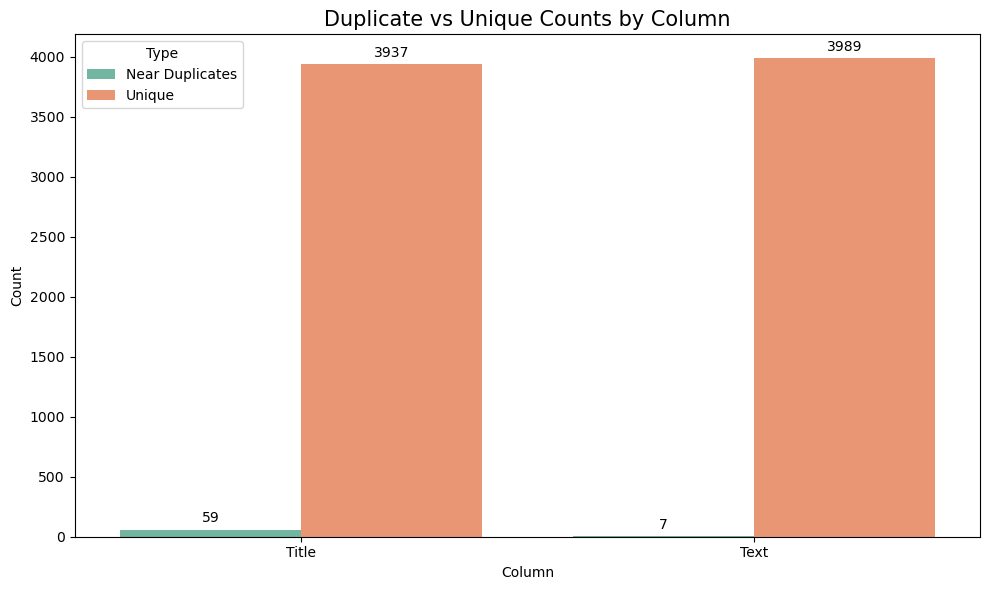

In [197]:
# ---- STEP 1: Filter by Product ID ----
industry_reviews_top_1 = industry_reviews.filter(col("parent_asin") == "B07JLQ24K9")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(industry_reviews_top_1, "title", jac=0.5)
title_total = industry_reviews_top_1.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(industry_reviews_top_1, "text", jac=0.5)
text_total = industry_reviews_top_1.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

25/05/29 21:56:09 INFO PlanChangeLogger: 19 + 12) / 100][Stage 1400:>(0 + 0) / 76]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:56:33 INFO PlanChangeLogger:                                        ]]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:56:44 INFO PlanChangeLogger:                                        6]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:56:44 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/29 21:56:54 INFO PlanChangeLogger:                                        ]6]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:57:04 INFO PlanChangeLogger:                                        6]]
 Dataproc Rule org.apache.s

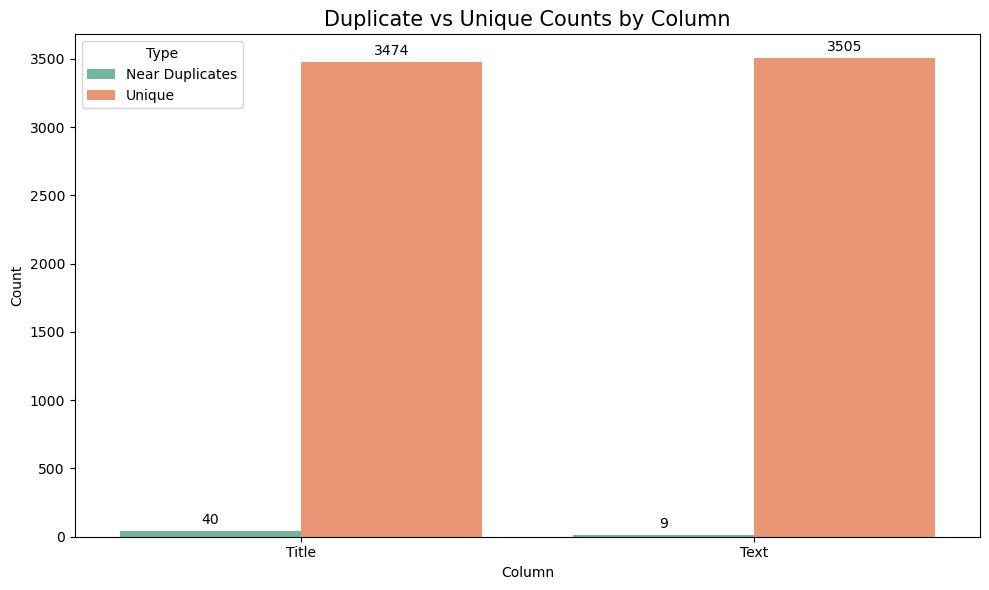

In [203]:
# ---- STEP 1: Filter by Product ID ----
industry_reviews_top_1 = industry_reviews.filter(col("parent_asin") == "B0C7F7HF75")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(industry_reviews_top_1, "title", jac=0.5)
title_total = industry_reviews_top_1.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(industry_reviews_top_1, "text", jac=0.5)
text_total = industry_reviews_top_1.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

25/05/29 21:57:34 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1466.5 KiB
25/05/29 21:57:45 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:57:55 INFO PlanChangeLogger:                                        6]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:57:55 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/29 21:58:06 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:58:17 INFO PlanChangeLogger:                          

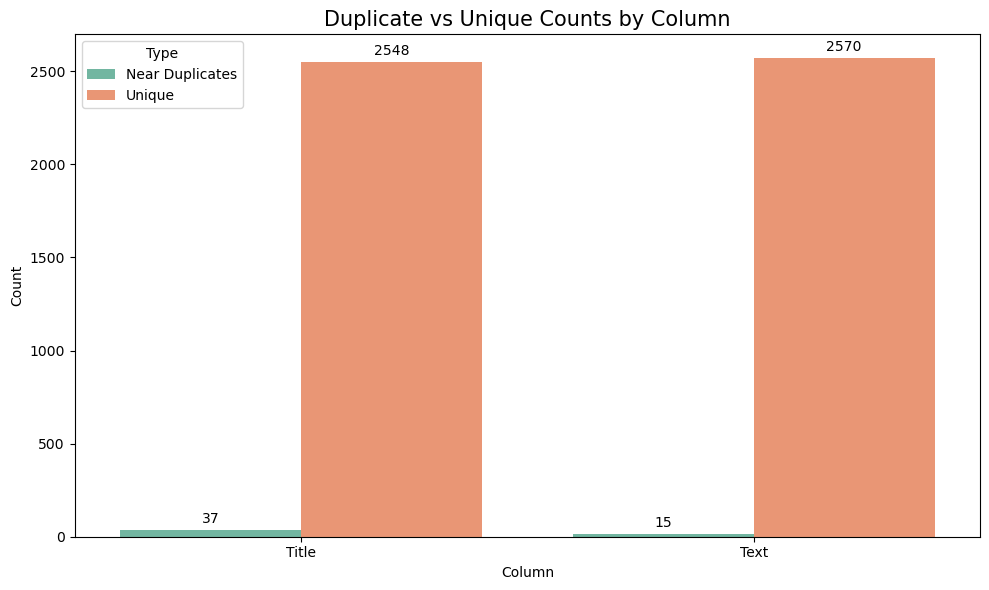

In [204]:
# ---- STEP 1: Filter by Product ID ----
industry_reviews_top_1 = industry_reviews.filter(col("parent_asin") == "B07DCRVBYX")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(industry_reviews_top_1, "title", jac=0.5)
title_total = industry_reviews_top_1.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(industry_reviews_top_1, "text", jac=0.5)
text_total = industry_reviews_top_1.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

25/05/29 21:58:41 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:58:50 INFO PlanChangeLogger:                                        ]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:58:56 INFO PlanChangeLogger:                                        ]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:58:56 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/29 21:59:04 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:59:13 INFO PlanChangeLogger:                                        6]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInfe

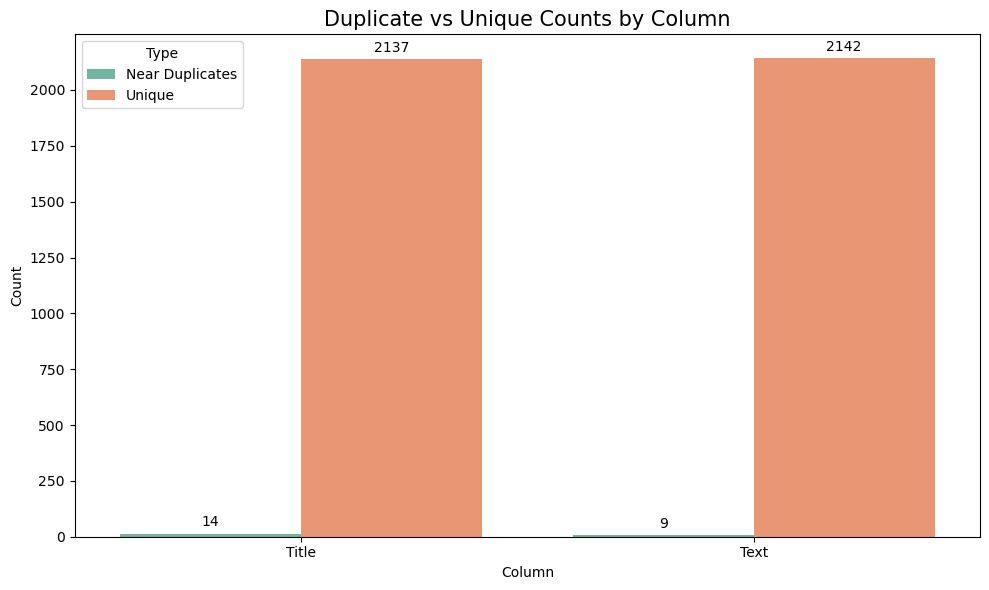

In [205]:
# ---- STEP 1: Filter by Product ID ----
industry_reviews_top_1 = industry_reviews.filter(col("parent_asin") == "B09H6H8B51")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(industry_reviews_top_1, "title", jac=0.5)
title_total = industry_reviews_top_1.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(industry_reviews_top_1, "text", jac=0.5)
text_total = industry_reviews_top_1.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

25/05/29 21:59:30 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:59:39 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:59:45 INFO PlanChangeLogger:                                        ]]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 21:59:45 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/29 21:59:53 INFO PlanChangeLogger:                                        0]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/29 22:00:01 INFO PlanChangeLogger:                                        0]
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedIn

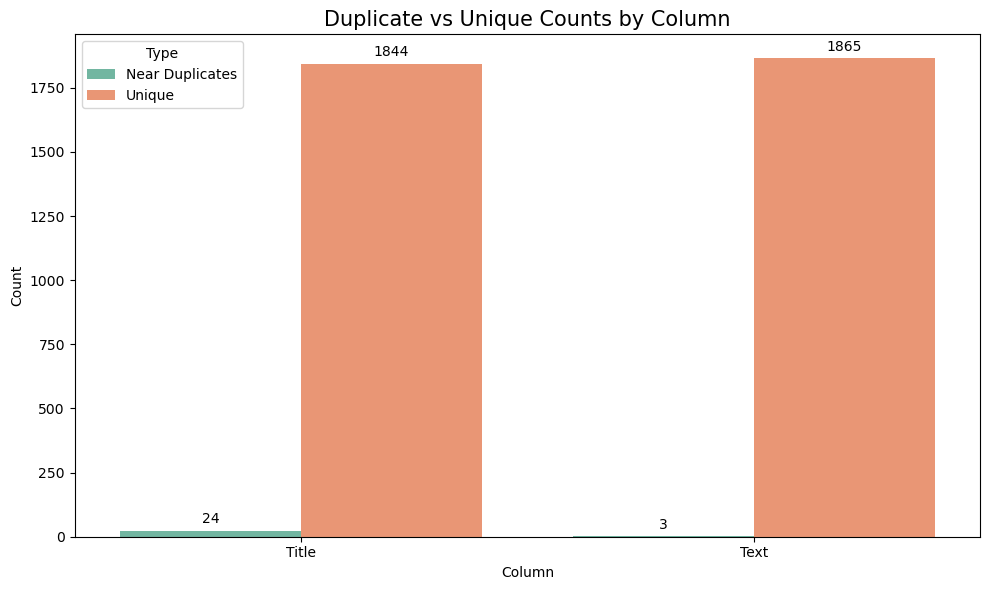

In [206]:
# ---- STEP 1: Filter by Product ID ----
industry_reviews_top_1 = industry_reviews.filter(col("parent_asin") == "B08Y1G3KRX")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(industry_reviews_top_1, "title", jac=0.5)
title_total = industry_reviews_top_1.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(industry_reviews_top_1, "text", jac=0.5)
text_total = industry_reviews_top_1.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

## Year-wise analysis for Titles

25/05/30 19:10:28 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.



+-------+------------------+----------------+
|distCol|text_A            |text_B          |
+-------+------------------+----------------+
|0.0    |Just okay         |Just okay       |
|0.0    |Are they worth it?|Not worth it    |
|0.0    |So worth it.      |So worth it     |
|0.0    |Not worth it      |Not worth it    |
|0.0    |Not so worth it   |Not worth it.   |
|0.0    |Not worth it      |Not worth your $|
|0.0    |Not worth it      |Not worth it    |
|0.0    |Not worth it      |Not worth it    |
|0.0    |Not worth it      |Not worth it    |
|0.0    |Not worth it      |Not worth it    |
+-------+------------------+----------------+
only showing top 10 rows



25/05/30 19:12:41 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 19:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1576.6 KiB
25/05/30 19:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1578.6 KiB
25/05/30 19:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1592.7 KiB
25/05/30 19:15:03 WARN DAGScheduler: Broadcasting large task binary with size 1578.7 KiB
25/05/30 19:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1595.3 KiB
25/05/30 19:15:17 WARN DAGScheduler: Broadcasting large task binary with size 1598.0 KiB
25/05/30 19:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1690.2 KiB
25/05/30 20:15:28 WARN DAGScheduler: Broadcasting large task binary with size 1616.4 KiB


+-------------------+-------------------------------+------------------------+
|distCol            |text_A                         |text_B                  |
+-------------------+-------------------------------+------------------------+
|0.0                |Too heavy!                     |Too heavy               |
|0.25               |Fingerprint sensor doesn't work|Fingerprint doesn't work|
|0.0                |Does not stay In               |Did not stay on.        |
|0.0                |Fits in perfectly.             |Fits perfectly          |
|0.33333333333333337|Fits great on the jeep!!       |Fits great!             |
|0.0                |Fits perfectly                 |Fits perfectly          |
|0.0                |Fits perfectly                 |Fits perfectly          |
|0.0                |Fits perfectly                 |Fits perfectly          |
|0.33333333333333337|Fits A12 perfectly.            |Fits perfectly          |
|0.33333333333333337|Fits perfect and very cute     

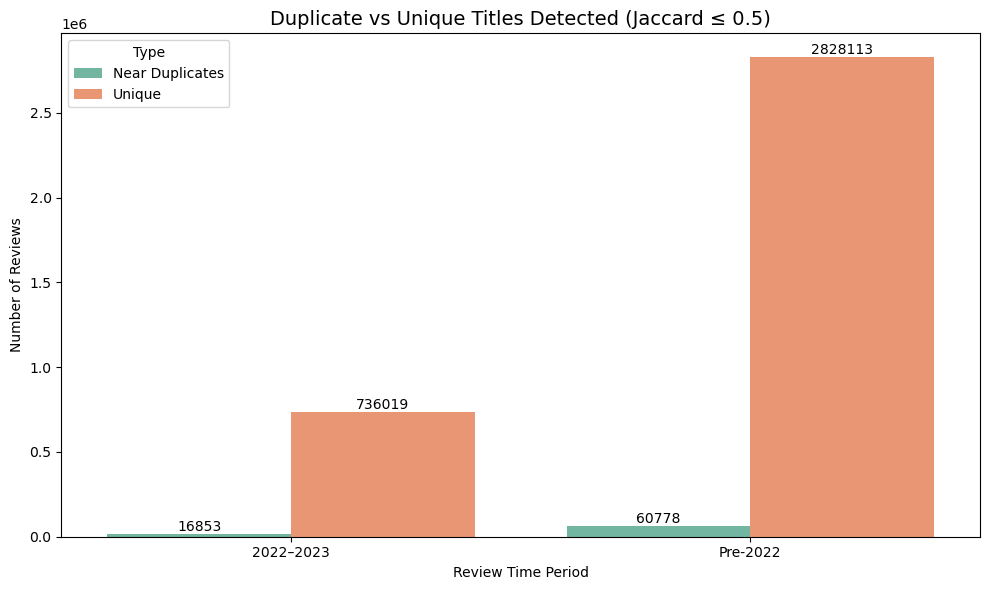

In [ ]:
# --- STEP 1: Split Data ---
review_dates = joined_df.withColumn("year", year(to_date("review_date")))

recent_reviews = review_dates.filter(col("year").between(2022, 2023)) \
                             .sample(withReplacement=False, fraction=0.1, seed=42)

older_reviews = review_dates.filter(col("year") < 2022) \
                            .sample(withReplacement=False, fraction=0.1, seed=42)

# --- STEP 2: Run Similarity Detection ---
jac_threshold = 0.5

# For recent reviews
df_dups_recent = similarity_analysis(recent_reviews, "title", jac=jac_threshold)
total_recent = recent_reviews.count()
dups_recent = df_dups_recent.select("text_A").distinct().count()
unique_recent = total_recent - dups_recent

df_dups_recent.show(10, truncate=False)

# For older reviews
df_dups_old = similarity_analysis(older_reviews, "title", jac=jac_threshold)
total_old = older_reviews.count()
dups_old = df_dups_old.select("text_A").distinct().count()
unique_old = total_old - dups_old

df_dups_old.show(10, truncate=False)

# --- STEP 3: Create Summary DataFrame ---
summary_df = pd.DataFrame({
    'Time Period': ['2022–2023', '2022–2023', 'Pre-2022', 'Pre-2022'],
    'Type': ['Near Duplicates', 'Unique', 'Near Duplicates', 'Unique'],
    'Count': [dups_recent, unique_recent, dups_old, unique_old]
})

# --- STEP 4: Plot Results ---
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Time Period", y="Count", hue="Type", palette="Set2")

plt.title(f"Duplicate vs Unique Titles Detected (Jaccard ≤ {jac_threshold})", fontsize=14)
plt.xlabel("Review Time Period")
plt.ylabel("Number of Reviews")
plt.tight_layout()

# Annotate counts on bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d')

plt.show()

## Year-wise analysis for Reviews

25/05/30 05:40:41 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 05:41:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/30 05:41:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/30 05:41:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/30 05:42:06 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/30 05:43:17 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 05:43:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/05/30 05:43:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/05/30 05:44:15 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/05/30 06:22:08 WARN DAGSc

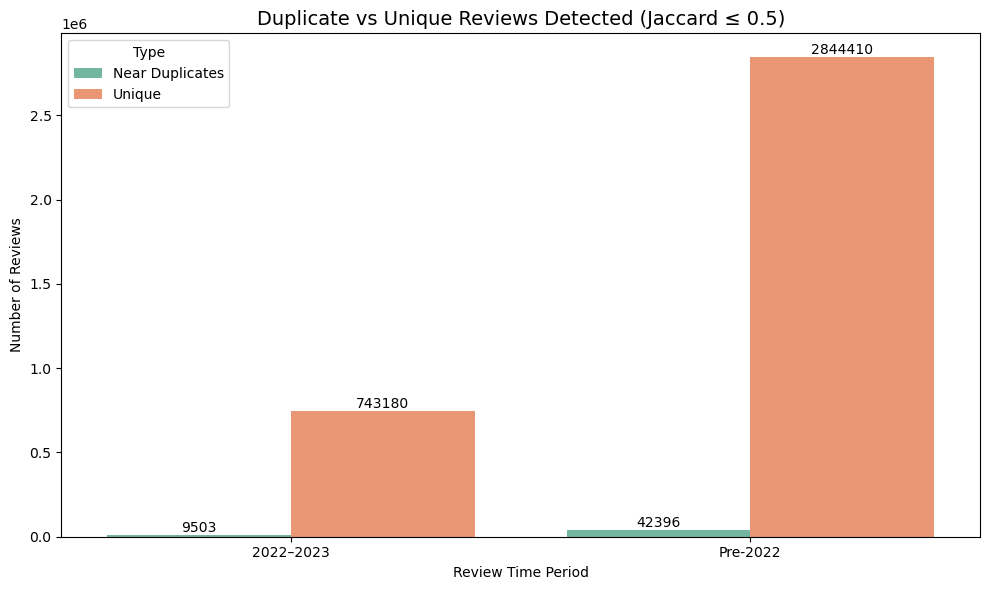

In [128]:
# --- STEP 1: Split Data ---
review_dates = joined_df.withColumn("year", year(to_date("review_date")))

recent_reviews = review_dates.filter(col("year").between(2022, 2023)) \
                             .sample(withReplacement=False, fraction=0.1, seed=42)

older_reviews = review_dates.filter(col("year") < 2022) \
                            .sample(withReplacement=False, fraction=0.1, seed=42)

# --- STEP 2: Run Similarity Detection ---
jac_threshold = 0.5

# For recent reviews
df_dups_recent = similarity_analysis(recent_reviews, "text", jac=jac_threshold)
total_recent = recent_reviews.count()
dups_recent = df_dups_recent.select("text_A").distinct().count()
unique_recent = total_recent - dups_recent

# For older reviews
df_dups_old = similarity_analysis(older_reviews, "text", jac=jac_threshold)
total_old = older_reviews.count()
dups_old = df_dups_old.select("text_A").distinct().count()
unique_old = total_old - dups_old

# --- STEP 3: Create Summary DataFrame ---
summary_df = pd.DataFrame({
    'Time Period': ['2022–2023', '2022–2023', 'Pre-2022', 'Pre-2022'],
    'Type': ['Near Duplicates', 'Unique', 'Near Duplicates', 'Unique'],
    'Count': [dups_recent, unique_recent, dups_old, unique_old]
})

# --- STEP 4: Plot Results ---
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Time Period", y="Count", hue="Type", palette="Set2")

plt.title(f"Duplicate vs Unique Reviews Detected (Jaccard ≤ {jac_threshold})", fontsize=14)
plt.xlabel("Review Time Period")
plt.ylabel("Number of Reviews")
plt.tight_layout()

# Annotate counts on bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d')

plt.show()

## Similarity Analysis for Outlier Reviews

25/05/29 23:49:26 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/29 23:49:44 WARN DAGScheduler: Broadcasting large task binary with size 1410.4 KiB
25/05/29 23:50:08 WARN DAGScheduler: Broadcasting large task binary with size 1463.3 KiB
25/05/29 23:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1403.2 KiB
25/05/29 23:52:18 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/29 23:52:42 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/05/29 23:53:11 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/05/29 23:57:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


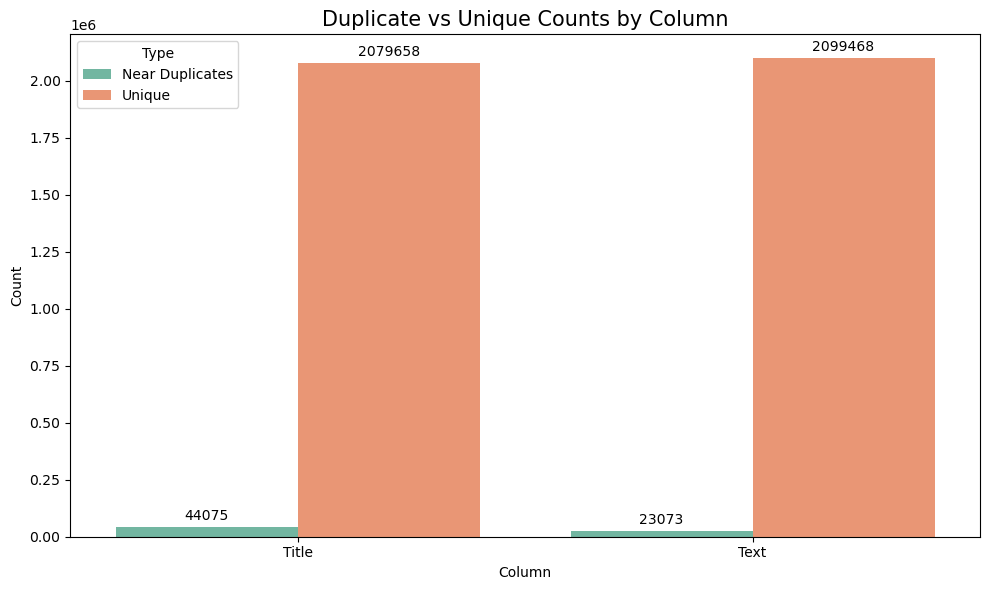

In [79]:
# --- STEP 1: Split Data ---
filtered_reviews_df = reviews_df.join(
    clean_meta_flat.select("parent_asin").distinct(),
    on="parent_asin",
    how="inner"
)
filtered_reviews_df = filtered_reviews_df.filter(col("verified_purchase")=="true")
filtered_reviews_df = filtered_reviews_df.drop("verified_purchase")

outliers_df = filtered_reviews_df.join(outliers.select("user_id"), on="user_id", how="inner")
outliers_df = outliers_df.select("text","title")

outliers_df = outliers_df.sample(withReplacement=False, fraction=0.1, seed=42)

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(outliers_df, "title", jac=0.5)
title_total = outliers_df.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(outliers_df, "text", jac=0.5)
text_total = outliers_df.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()

# Unusual Product Similarity Analysis

25/05/30 20:27:21 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/30 20:27:53 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/30 20:28:04 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/30 20:28:04 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 20:28:19 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.



+-------------------+----------------------------+------------------------+
|distCol            |text_A                      |text_B                  |
+-------------------+----------------------------+------------------------+
|0.4                |Easy to use and works great!|Easy to use, great grip |
|0.0                |Not sturdy                  |Very sturdy             |
|0.0                |Works well                  |Works well              |
|0.0                |Works great                 |Works great!            |
|0.33333333333333337|Hands free                  |Hands free quality!     |
|0.0                |Five Stars                  |Five Stars              |
|0.0                |Great product               |Great product!!         |
|0.33333333333333337|Great product and service!  |Great product!          |
|0.0                |Five Stars                  |Five Stars              |
|0.0                |Great product               |Great product!!         |
|0.333333333

25/05/30 20:28:31 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/30 20:28:44 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/30 20:28:55 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.

25/05/30 20:28:55 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.ConvertToLeftSemiJoin effective 1 times.

25/05/30 20:29:10 INFO PlanChangeLogger:                                        
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.AdvancedInferFilter effective 1 times.



+-------------------+-------------------------------+---------------------------------+
|distCol            |text_A                         |text_B                           |
+-------------------+-------------------------------+---------------------------------+
|0.33333333333333337|Easy to install                |Easy to install and use!         |
|0.0                |I love it                      |I love it                        |
|0.0                |It works well.                 |It works well!                   |
|0.0                |Great product!                 |Great product!                   |
|0.33333333333333337|Great product, very sturdy!    |Great product !                  |
|0.0                |Great product!                 |Great product !                  |
|0.0                |Great product!                 |Great product !                  |
|0.0                |Works great                    |Works great                      |
|0.0                |Easy to ins

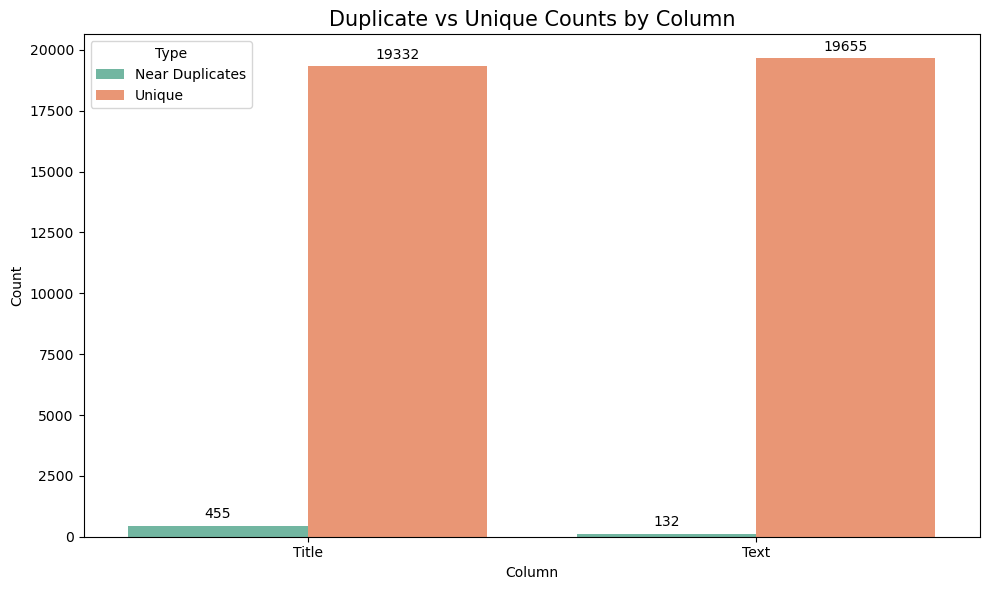

In [96]:
# ---- STEP 1: Filter by Product ID ----
beam_reviews = joined_df.filter(col("parent_asin") == "B073R68TSH")

# ---- STEP 2: Run similarity analysis for title ----
df_dups_title = similarity_analysis(beam_reviews, "title", jac=0.5)
title_total = beam_reviews.count()
title_dups = df_dups_title.select("text_A").distinct().count()
title_unique = title_total - title_dups

df_dups_title.show(truncate=False)

# ---- STEP 3: Run similarity analysis for text ----
df_dups_text = similarity_analysis(beam_reviews, "text", jac=0.5)
text_total = beam_reviews.select("text").filter(col("text").isNotNull()).count()
text_dups = df_dups_text.select("text_A").distinct().count()
text_unique = text_total - text_dups

df_dups_text.show(truncate=False)

# ---- STEP 4: Prepare DataFrame for Plotting ----
bar_df = pd.DataFrame({
    'type': ['Near Duplicates', 'Unique'] * 2,
    'count': [title_dups, title_unique, text_dups, text_unique],
    'column': ['Title'] * 2 + ['Text'] * 2
})

# ---- STEP 5: Plot Side-by-Side Barplots ----
plt.figure(figsize=(10, 6))
sns.barplot(data=bar_df, x="column", y="count", hue="type", palette='Set2')

plt.title("Duplicate vs Unique Counts by Column", fontsize=15)
plt.xlabel("Column")
plt.ylabel("Count")
plt.legend(title="Type")
plt.tight_layout()

# Annotate bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.show()